# **SO YOU WANT TO LIVE IN LONDON?**

***A multidimensional borough analysis of house prices, affordability, and liveability across London's 33 boroughs***

**Team Members:** 59183, 70639, 72294  
**Course:** ST445 - Managing and Visualising Data  

## **Table of Contents**

1. Data Collection
2. Data Cleaning
3. Data Integration
4. Exploratory Data Analysis (EDA) and Visualisations
5. Modelling - Linear Regression
6. Conclusion

## **Introduction & Research Context**

##### Background
London faces a housing affordability crisis, with median house prices being much higher than median earnings. However, not all boroughs are created equal. This analysis seeks to understand the multidimensional trade-offs between:
- Housing affordability (prices and earnings)
- Transportation connectivity
- Safety and crime rates
- Economic opportunity

##### Research Question
**Primary Question:**  
To determine which London boroughs offer good quality of life relative to housing costs, and to understand how different boroughs compare on transport connectivity, economic opportunities, and crime.

**Sub-questions:**
1. How do transport connectivity and housing prices correlate across boroughs?
2. Which boroughs offer the best value (good transport, economic opportunities, low crime, moderate cost)?
3. Can we predict house prices using factors like transport, safety and economic opportunities?

## **Part 1: Data Collection**

### **Overview**
This notebook collects data from multiple sources to analyze quality of life and housing costs across London's 33 boroughs. We combine transport connectivity (rail + bus), crime rates, economic indicators, and housing prices to create a comprehensive livability assessment.

---

### **Data Sources**

| Source | Type | Key Indicators | Access | Rate Limits | Documentation |
|--------|------|----------------|--------|-------------|---------------|
| **Transport for London (TfL) Unified API** | REST API | - Tube/rail/DLR/Elizabeth Line stations<br>- Bus routes & stops<br>- Station coordinates<br>- Line information | Free, no key required for our use | 500 requests/min | [TfL API Docs](https://api.tfl.gov.uk/) |
| **Police.uk API** | REST API | - Crime counts by type<br>- Location coordinates<br>- Crime categories<br>- Monthly data | Free, no key required | 15 requests/sec | [Police.uk API](https://data.police.uk/docs/) |
| **UK Land Registry Price Paid** | CSV Download | - Property transaction prices<br>- Property type<br>- Postcode<br>- Transaction dates | Free download | N/A (bulk download) | [Land Registry](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) |
| **London Datastore** | CSV/Excel/GeoJSON | - Borough boundaries (GeoJSON)<br>- Population by borough<br>- Earnings data<br>- Jobs & job density | Free download | N/A | [London Datastore](https://data.london.gov.uk/) |

---

### **Collection Strategy**

#### **Phase 1: API-Based Collection**
1. **TfL Stations API**: Collect all tube/rail station data with coordinates
2. **TfL Bus Routes API**: Collect 621 bus routes with stop locations
3. **Police.uk API**: Query crime data for October 2024 across all 33 boroughs

#### **Phase 2: Direct Downloads**
1. **Land Registry**: Download 2024 Price Paid data (all England & Wales)
2. **London Datastore - GIS**: Download borough boundary shapefiles
3. **London Datastore - Population**: API download of borough population data

#### **Phase 3: Manual Downloads**
1. **Earnings**: Download earnings-residence-borough.xlsx from London Datastore
2. **Jobs Density**: Download jobs-and-job-density.xlsx from London Datastore
3. Move files from Downloads folder to `data/raw/`

#### **Phase 4: Data Storage**
- Save all raw data to `data/raw/` folder
- Maintain original file formats
- Keep large files (>100MB) local only (not committed to GitHub)
- Document data sources and collection dates

---

### **Outputs**

By the end of this section, we will have:
- `data/raw/tfl_stations.csv` - 2,646 London transport station records
- `data/raw/tfl_bus_routes.csv` - 674 bus route identifiers
- `data/raw/tfl_bus_route_stops.json` - 80,479 bus stop records (573 MB)
- `data/raw/police_crime_data.csv` - 30,774 crime incidents (Oct 2024)
- `data/raw/land_registry_2024.csv` - 913,320 UK property transactions (152 MB)
- `data/raw/statistical-gis-boundaries-london/` - Borough boundary shapefiles
- `data/raw/borough_population.csv` - Population by borough (multi-year)
- `data/raw/borough_earnings.xlsx` - Median hourly earnings (Dec 2024)
- `data/raw/borough_jobs_density.xlsx` - Jobs and job density (Dec 2023)

---



- **Geographic Scope**: All 33 London boroughs (City of London + 32 boroughs)
- **Time Period**: October 2024 for crime; full year 2024 for property prices; Dec 2023-2024 for economic data
- **Large Files**: Land Registry (152 MB) and bus stops (573 MB) will NOT be committed to GitHub
- **Data Not Collected**: Air quality (WAQI), green space (dataset unavailable), schools (data too old)
- **API Keys**: TfL and Police.uk APIs work without authentication for our use case
- **Success Rate**: 621/674 bus routes collected (92% success); 53 routes failed due to timeouts or defunct routes

**Importing Libraries**

- There are several libraries we will use, with some notable ones necessary for advanced visualisations 

- We will also import scikitlearn libraries that can help us with the modelling and preprocessing in the latter parts 

- We will also download the necessary files for mappoing the London boroughs

In [8]:
import zipfile
import os
import requests
import json
import pandas as pd
import time
from datetime import datetime, timedelta
import shutil
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [9]:
# Creating directory to storeheavy raw data
os.makedirs('data/raw', exist_ok=True)

url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"

print("Downloading London borough boundaries...")
response = requests.get(url)

if response.status_code == 200:
    
    with open('data/raw/london_boundaries.zip', 'wb') as f:
        f.write(response.content)
    print("Downloaded successfully!")
else:
    print(f"Download failed with status code: {response.status_code}")

Downloaded successfully!


In [10]:
# Extract the zip file
print("Extracting london_boundaries.zip...")
with zipfile.ZipFile('data/raw/london_boundaries.zip', 'r') as zip_ref:
    zip_ref.extractall('data/raw/')

print("Extracted")

# Checking files
files = os.listdir('data/raw/')
print(f"\nAll files in data/raw/:")
for f in files:
    print(f"  - {f}")

# Finding geojson files
geojson_files = [f for f in files if f.endswith('.geojson')]
print(f"\nGeoJSON files found:")
for f in geojson_files:
    print(f"  - {f}")

Extracting london_boundaries.zip...
Extracted

All files in data/raw/:
  - borough_population.csv
  - land_registry_2024.csv
  - london_boundaries.zip
  - police_crime_data.csv
  - police_crime_data.json
  - statistical-gis-boundaries-london
  - tfl_bus_routes.csv
  - tfl_bus_routes.json
  - tfl_bus_route_stops.json
  - tfl_stations.csv
  - tfl_stations.json

GeoJSON files found:


In [11]:
# Checking extracted folder
folder_path = 'data/raw/statistical-gis-boundaries-london'
files = os.listdir(folder_path)

print(f"Files inside statistical-gis-boundaries-london/:")
for f in files:
    print(f"  - {f}")

# Find borough-related files
borough_files = [f for f in files if 'borough' in f.lower()]
print(f"\nBorough-related files:")
for f in borough_files:
    print(f"  - {f}")

Files inside statistical-gis-boundaries-london/:
  - ESRI
  - Geography-licensing.pdf
  - MapInfo

Borough-related files:


In [12]:
# Check ESRI folder
print("Files in ESRI folder:")
esri_files = os.listdir('data/raw/statistical-gis-boundaries-london/ESRI')
for f in esri_files:
    print(f"  - {f}")

print("\n" + "="*50 + "\n")

# Check MapInfo folder
print("Files in MapInfo folder:")
mapinfo_files = os.listdir('data/raw/statistical-gis-boundaries-london/MapInfo')
for f in mapinfo_files:
    print(f"  - {f}")

Files in ESRI folder:
  - London_Borough_Excluding_MHW.dbf
  - London_Borough_Excluding_MHW.GSS_CODE.atx
  - London_Borough_Excluding_MHW.NAME.atx
  - London_Borough_Excluding_MHW.prj
  - London_Borough_Excluding_MHW.sbn
  - London_Borough_Excluding_MHW.sbx
  - London_Borough_Excluding_MHW.shp
  - London_Borough_Excluding_MHW.shp.xml
  - London_Borough_Excluding_MHW.shx
  - London_Ward.BOROUGH.atx
  - London_Ward.cpg
  - London_Ward.dbf
  - London_Ward.GSS_CODE.atx
  - London_Ward.LB_GSS_CD.atx
  - London_Ward.prj
  - London_Ward.sbn
  - London_Ward.sbx
  - London_Ward.shp
  - London_Ward.shp.xml
  - London_Ward.shx
  - London_Ward_CityMerged.BOROUGH.atx
  - London_Ward_CityMerged.cpg
  - London_Ward_CityMerged.dbf
  - London_Ward_CityMerged.GSS_CODE.atx
  - London_Ward_CityMerged.LB_GSS_CD.atx
  - London_Ward_CityMerged.prj
  - London_Ward_CityMerged.sbn
  - London_Ward_CityMerged.sbx
  - London_Ward_CityMerged.shp
  - London_Ward_CityMerged.shp.xml
  - London_Ward_CityMerged.shx
  - 

Loading London borough boundaries...

✓ Loaded 33 boroughs

Columns available: ['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'geometry']

First few boroughs:
                   NAME   GSS_CODE
0  Kingston upon Thames  E09000021
1               Croydon  E09000008
2               Bromley  E09000006
3              Hounslow  E09000018
4                Ealing  E09000009
5              Havering  E09000016
6            Hillingdon  E09000017
7                Harrow  E09000015
8                 Brent  E09000005
9                Barnet  E09000003


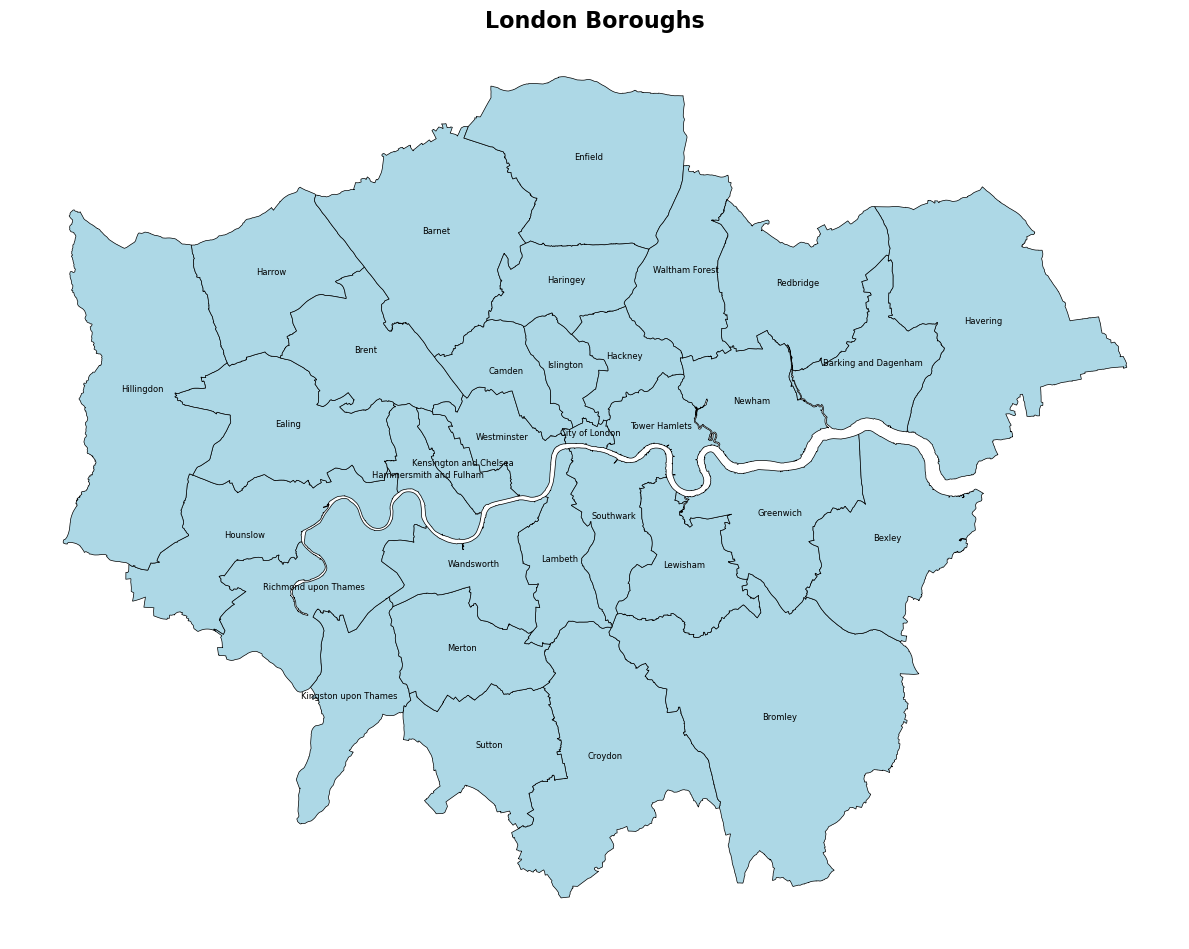


✓ Visualization complete!

Borough data shape: (33, 8)


In [13]:
# Load the borough boundaries
print("Loading London borough boundaries...")
borough_path = 'data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs = gpd.read_file(borough_path)

print(f"\n✓ Loaded {len(boroughs)} boroughs")
print(f"\nColumns available: {list(boroughs.columns)}")
print(f"\nFirst few boroughs:")
print(boroughs[['NAME', 'GSS_CODE']].head(10))

#Visulazing the boroughs
fig, ax = plt.subplots(figsize=(12, 10))
boroughs.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5)
boroughs.apply(lambda x: ax.text(x.geometry.centroid.x, x.geometry.centroid.y, 
                                  x['NAME'], fontsize=6, ha='center'), axis=1)
ax.set_title('London Boroughs', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"\nBorough data shape: {boroughs.shape}")

**TFL Data Collection**

- One key measure of connectivity will be tube stations and lines

- TFL has a fantastic API that has rich data related to this 

- We will use the coordinates to then map the stations to the Boroughs. This will give us a good visual indicator of connectivity that will be useful later 

In [14]:
# TfL API endpoint for all stations
url = "https://api.tfl.gov.uk/StopPoint/Mode/tube,overground,dlr,elizabeth-line"

print("Fetching TfL station data...")
response = requests.get(url)

if response.status_code == 200:
    print(f" Success!")
    
    stations_data = response.json()
    print(f" Retrieved {len(stations_data['stopPoints'])} stations")
    
    stations_list = []
    for station in stations_data['stopPoints']:
        stations_list.append({
            'id': station.get('id'),
            'name': station.get('commonName'),
            'lat': station.get('lat'),
            'lon': station.get('lon'),
            'modes': ','.join(station.get('modes', []))
        })
    
    stations_df = pd.DataFrame(stations_list)
    print(f"\nFirst 10 stations:")
    print(stations_df.head(10))
    
    with open('data/raw/tfl_stations.json', 'w') as f:
        json.dump(stations_data, f, indent=2)
    stations_df.to_csv('data/raw/tfl_stations.csv', index=False)
    
    print(f"\n Saved {len(stations_df)} stations!")
    
else:
    print(f" Failed: {response.status_code}")

Fetching TfL station data...
 Success!
 Retrieved 2646 stations

First 10 stations:
             id                                    name        lat       lon  \
0  0400ZZLUAMS0            Amersham Underground Station  51.674206 -0.607362   
1  0400ZZLUCAL0  Chalfont & Latimer Underground Station  51.667915 -0.560616   
2  0400ZZLUCAL1  Chalfont & Latimer Underground Station  51.668122 -0.560624   
3  0400ZZLUCSM0             Chesham Underground Station  51.705227 -0.611113   
4   2100BUSHEY0                     Bushey Rail Station  51.645628 -0.385600   
5   2100BUSHEY1                     Bushey Rail Station  51.645754 -0.384367   
6  2100BUSHYDC0                     Bushey Rail Station  51.645691 -0.384355   
7  2100BUSHYDC1                     Bushey Rail Station  51.645691 -0.385612   
8  2100CHESHNT0                   Cheshunt Rail Station  51.702949 -0.024101   
9  2100CRPNDPK0            Carpenders Park Rail Station  51.628564 -0.385874   

        modes  
0        tube  
1  

Boroughs CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Stations CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting

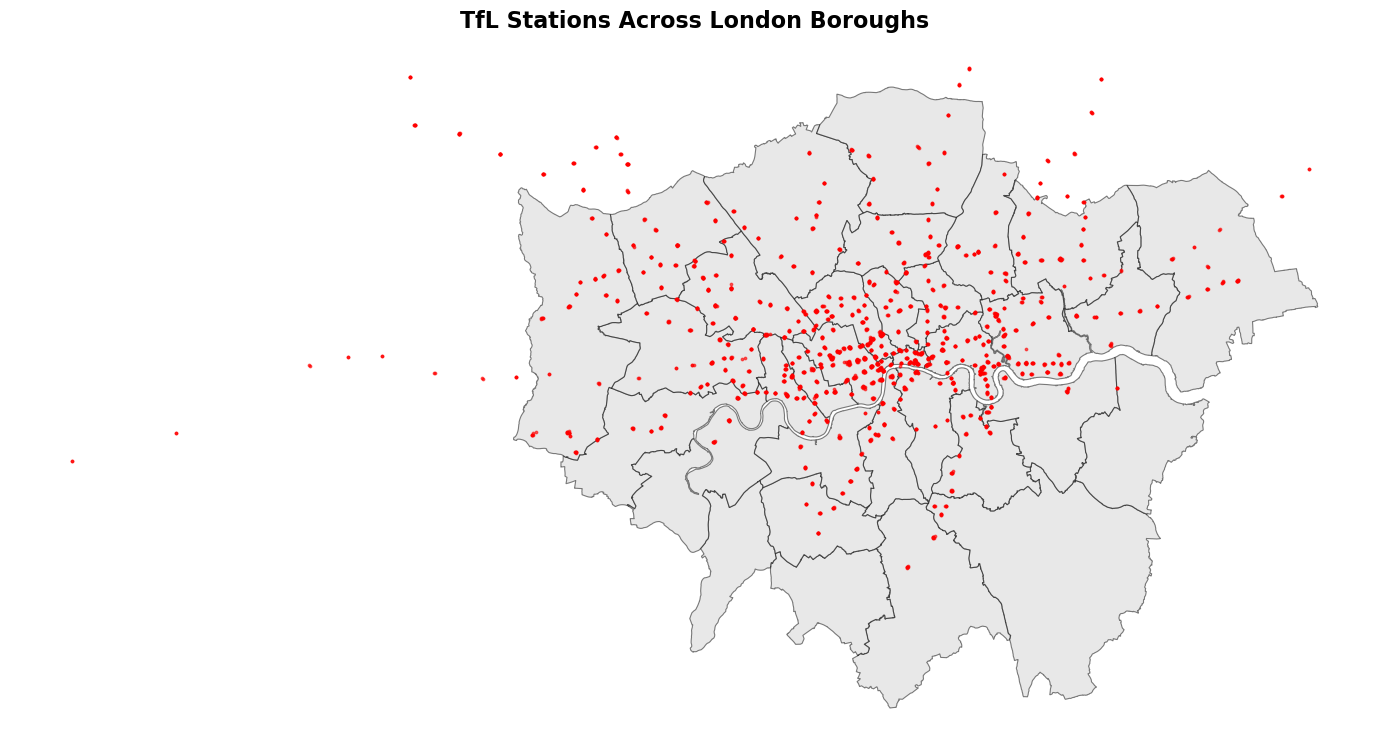


 Map complete!


In [15]:
# Load the boroughs from before
borough_path = 'data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs = gpd.read_file(borough_path)

# Load the stations we just saved
stations_df = pd.read_csv('data/raw/tfl_stations.csv')

# Convert stations to GeoDataFrame
from shapely.geometry import Point
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=[Point(lon, lat) for lon, lat in zip(stations_df['lon'], stations_df['lat'])],
    crs='EPSG:4326'  # Standard lat/lon
)

# Ensuring both use the same CRS
stations_gdf = stations_gdf.to_crs(boroughs.crs)

print(f"Boroughs CRS: {boroughs.crs}")
print(f"Stations CRS: {stations_gdf.crs}")
print(f"Stations: {len(stations_gdf)}")
print(f"Boroughs: {len(boroughs)}")

fig, ax = plt.subplots(figsize=(14, 12))

boroughs.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.8, alpha=0.5)
stations_gdf.plot(ax=ax, color='red', markersize=3, alpha=0.6)

ax.set_title('TfL Stations Across London Boroughs', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("\n Map complete!")

In [16]:
# Spatial join to see which stations are in boroughs
stations_in_london = gpd.sjoin(stations_gdf, boroughs, how='inner', predicate='within')

print(f"Total stations: {len(stations_gdf)}")
print(f"Stations inside London boroughs: {len(stations_in_london)}")
print(f"Stations outside London: {len(stations_gdf) - len(stations_in_london)}")

Total stations: 2646
Stations inside London boroughs: 2513
Stations outside London: 133


In [17]:
# Count stations per borough
borough_stations = stations_in_london.groupby('NAME').size().reset_index(name='station_count')
borough_stations = borough_stations.sort_values('station_count')

# Find boroughs with zero stations
boroughs_with_data = set(borough_stations['NAME'])
all_boroughs = set(boroughs['NAME'])
boroughs_no_stations = all_boroughs - boroughs_with_data

print(f"Boroughs with NO stations ({len(boroughs_no_stations)}):")
for b in sorted(boroughs_no_stations):
    print(f"  - {b}")

print(f"\n\nBoroughs with FEWEST stations:")
print(borough_stations.head(10))

print(f"\n\nBoroughs with MOST stations:")
print(borough_stations.tail(10))

Boroughs with NO stations (3):
  - Bexley
  - Kingston upon Thames
  - Sutton


Boroughs with FEWEST stations:
                    NAME  station_count
3                Bromley             13
6                Croydon             13
24  Richmond upon Thames             18
21                Merton             26
0   Barking and Dagenham             34
14              Havering             36
9              Greenwich             43
20              Lewisham             44
28            Wandsworth             47
16              Hounslow             48


Boroughs with MOST stations:
                      NAME  station_count
17               Islington             88
5           City of London             90
15              Hillingdon             99
11  Hammersmith and Fulham            105
7                   Ealing            106
2                    Brent            165
4                   Camden            175
22                  Newham            186
26           Tower Hamlets            19

**Notes**: 

- The Boroughs with no stations bit checks out: Bexley, Kingston upon Thames and Sutton are on the outskirts of the city, so it makes sense 

- What I find startling is the the massive number of stations in some Broughs, 291 in Westminster looks unlikely 

- What I suspect is that there are multiple entries per stations, possibly one for each platform 

- This will need to be addressed later on, let's just look into it a little more, to better diagnose the issue.

In [18]:
# Check Westminster stations for duplicates
westminster_stations = stations_in_london[stations_in_london['NAME'] == 'Westminster']

print(f"Westminster has {len(westminster_stations)} station records")
print("\nLet's look at unique station names in Westminster:")

westminster_unique = westminster_stations['name'].value_counts().head(20)
print(westminster_unique)

print(f"\nTotal unique station names: {westminster_stations['name'].nunique()}")
print(f"Total records: {len(westminster_stations)}")
print(f"\nDifference = {len(westminster_stations) - westminster_stations['name'].nunique()} duplicate entries")

Westminster has 291 station records

Let's look at unique station names in Westminster:
name
Marble Arch Station                               13
Bond Street Station                               10
Baker Street Underground Station                  10
Paddington Underground Station                    10
Oxford Circus Station                              9
Oxford Circus Underground Station                  8
Piccadilly Circus                                  8
Embankment Underground Station                     8
Hyde Park Corner Station                           7
Charing Cross Underground Station                  7
Green Park Underground Station                     7
Charing Cross Station                              6
Charing Cross Stn  / Trafalgar Square              6
Piccadilly Circus Underground Station              6
Leicester Square Underground Station               6
Green Park Station                                 6
Edgware Road (Circle Line) Underground Station     6
Victor

**Data Quality Note: TfL Station Duplicates**

The TfL API returns separate records for each platform/entrance. For example:
- Westminster: 291 records → 77 unique stations
- Marble Arch: 13 platform/entrance records for one station

**Solution:** In the Data Cleaning bit, we'll deduplicate by station name, keeping one representative record per unique station.

**Crime Data**

- We will use the police UK API to collect some data on crime in London 

- Timeframe: We will query for the last 12 months 

- After encountering some initial errors, we figured out the Time format 

- We also converted the boroughs location format so that we could match crime to Boroughs 


In [19]:
# Get the last 12 months
today = datetime.now()
months = []
for i in range(12):
    date = today - timedelta(days=30*i)
    months.append(date.strftime('%Y-%m'))

print(f"Will collect crime data for these months: {months}")

# Get borough centroids for querying
boroughs['centroid'] = boroughs.geometry.centroid
boroughs['cent_lat'] = boroughs.centroid.y
boroughs['cent_lon'] = boroughs.centroid.x

print(f"\nBoroughs with centroids calculated: {len(boroughs)}")
print(boroughs[['NAME', 'cent_lat', 'cent_lon']].head())

Will collect crime data for these months: ['2026-02', '2026-01', '2025-12', '2025-11', '2025-10', '2025-09', '2025-08', '2025-07', '2025-06', '2025-05', '2025-04', '2025-03']

Boroughs with centroids calculated: 33
                   NAME       cent_lat       cent_lon
0  Kingston upon Thames  166820.011490  519297.634807
1               Croydon  163541.243574  533290.153919
2               Bromley  165655.521340  542895.511607
3              Hounslow  175643.224320  513515.505536
4                Ealing  181715.495617  515887.937770


In [20]:
# Convert borough centroids to proper lat/lon (EPSG:4326)
boroughs_latlon = boroughs.to_crs('EPSG:4326')
boroughs_latlon['centroid'] = boroughs_latlon.geometry.centroid
boroughs_latlon['cent_lat'] = boroughs_latlon.centroid.y
boroughs_latlon['cent_lon'] = boroughs_latlon.centroid.x

print("Boroughs with proper lat/lon centroids:")
print(boroughs_latlon[['NAME', 'cent_lat', 'cent_lon']].head(10))

Boroughs with proper lat/lon centroids:
                   NAME   cent_lat  cent_lon
0  Kingston upon Thames  51.387906 -0.286900
1               Croydon  51.355335 -0.087157
2               Bromley  51.371999  0.051524
3              Hounslow  51.468378 -0.367123
4                Ealing  51.522475 -0.331026
5              Havering  51.564387  0.221108
6            Hillingdon  51.541513 -0.445658
7                Harrow  51.597723 -0.341267
8                 Brent  51.558556 -0.267821
9                Barnet  51.616027 -0.210017


In [21]:
# Police.uk API endpoint
base_url = "https://data.police.uk/api/crimes-street/all-crime"

# We'll collect crime data for the most recent available month
# Police.uk data last avaiable is October 2024
target_month = "2024-10"



all_crimes = []
borough_names = []

for idx, row in boroughs_latlon.iterrows():
    borough = row['NAME']
    lat = row['cent_lat']
    lon = row['cent_lon']
    
    # Query crime within ~approx. 1 mile radius of borough center
    params = {
        'lat': lat,
        'lng': lon,
        'date': target_month
    }
    
    try:
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            crimes = response.json()
            print(f"✓ {borough}: {len(crimes)} crimes")
            
            for crime in crimes:
                crime['borough_query'] = borough
            
            all_crimes.extend(crimes)
            borough_names.append(borough)
            
        else:
            print(f" {borough}: Failed (status {response.status_code})")
        
        time.sleep(0.5)
        
    except Exception as e:
        print(f" {borough}: Error - {e}")

print(f"\n Total crimes collected: {len(all_crimes)}")

with open('data/raw/police_crime_data.json', 'w') as f:
    json.dump(all_crimes, f, indent=2)

# Converting to DataFrame
crimes_df = pd.DataFrame(all_crimes)
print(f"\nCrime data shape: {crimes_df.shape}")
print(f"\nCrime categories:")
print(crimes_df['category'].value_counts())

✓ Kingston upon Thames: 233 crimes
✓ Croydon: 259 crimes
✓ Bromley: 130 crimes
✓ Hounslow: 835 crimes
✓ Ealing: 542 crimes
✓ Havering: 195 crimes
✓ Hillingdon: 177 crimes
✓ Harrow: 484 crimes
✓ Brent: 766 crimes
✓ Barnet: 130 crimes
✓ Lambeth: 1429 crimes
✓ Southwark: 1444 crimes
✓ Lewisham: 858 crimes
✓ Greenwich: 374 crimes
✓ Bexley: 355 crimes
✓ Enfield: 371 crimes
✓ Waltham Forest: 917 crimes
✓ Redbridge: 415 crimes
✓ Sutton: 486 crimes
✓ Richmond upon Thames: 208 crimes
✓ Merton: 602 crimes
✓ Wandsworth: 590 crimes
✓ Hammersmith and Fulham: 1656 crimes
✓ Kensington and Chelsea: 1465 crimes
✓ Westminster: 3330 crimes
✓ Camden: 1452 crimes
✓ Tower Hamlets: 1500 crimes
✓ Islington: 1748 crimes
✓ Hackney: 1772 crimes
✓ Haringey: 1027 crimes
✓ Newham: 1333 crimes
✓ Barking and Dagenham: 599 crimes
✓ City of London: 3092 crimes

 Total crimes collected: 30774

Crime data shape: (30774, 10)

Crime categories:
category
violent-crime            6302
anti-social-behaviour    5780
theft-from

In [22]:
crimes_df.to_csv('data/raw/police_crime_data.csv', index=False)

print("Saved to data/raw/police_crime_data.json and .csv")

print("\nSample crime record:")
print(crimes_df.iloc[0].to_dict())

print("\n\nCrimes by borough (approximation based on query location):")
borough_crime_counts = crimes_df['borough_query'].value_counts()
print(borough_crime_counts.head(10))

Saved to data/raw/police_crime_data.json and .csv

Sample crime record:
{'category': 'anti-social-behaviour', 'location_type': 'Force', 'location': {'latitude': '51.380049', 'street': {'id': 1661049, 'name': 'On or near Broad Oaks'}, 'longitude': '-0.282431'}, 'context': '', 'outcome_status': None, 'persistent_id': '', 'id': 123858838, 'location_subtype': '', 'month': '2024-10', 'borough_query': 'Kingston upon Thames'}


Crimes by borough (approximation based on query location):
borough_query
Westminster               3330
City of London            3092
Hackney                   1772
Islington                 1748
Hammersmith and Fulham    1656
Tower Hamlets             1500
Kensington and Chelsea    1465
Camden                    1452
Southwark                 1444
Lambeth                   1429
Name: count, dtype: int64


**Property Price Data (UK Land Registry)**


- Downloaded the complete 2024 Price Paid dataset from UK Land Registry
- Contains ALL property transactions across England and Wales
- File size is MASSIVE: 151.8 MB (913,320 transactions)

- Upon further scrutiny, we realised that the data includes properties from across the UK (Bedford, Luton, etc.)
- We'll need to filter to London only, and then use the postcodes to try and match to Boroughs 
- Each transaction includes: price, date, postcode, property type, location



In [23]:
# Land Registry CSV file for 2024
print("Downloading Land Registry price data for 2024...")

url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2024.csv"

print("Starting download (this may take 1-2 minutes for large file)...")
response = requests.get(url, stream=True)

if response.status_code == 200:
    print(" Download successful! Saving...")
    
    with open('data/raw/land_registry_2024.csv', 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    print(" Saved to data/raw/land_registry_2024.csv")
    
    print("\nLoading preview...")
    df = pd.read_csv('data/raw/land_registry_2024.csv', 
                     nrows=1000,
                     names=['transaction_id', 'price', 'date', 'postcode', 'property_type', 
                            'new_build', 'duration', 'paon', 'saon', 'street', 'locality',
                            'town', 'district', 'county', 'ppd_type', 'record_status'])
    
    print(f"\nFirst few transactions:")
    print(df[['price', 'date', 'postcode', 'property_type', 'town']].head())
    
else:
    print(f"✗ Download failed: {response.status_code}")

Starting download (this may take 1-2 minutes for large file)...
 Download successful! Saving...
 Saved to data/raw/land_registry_2024.csv

Loading preview...

First few transactions:
    price              date  postcode property_type       town
0  320000  2024-03-20 00:00   NR9 5FP             D    NORWICH
1  291000  2024-04-26 00:00  NR20 3UF             D    DEREHAM
2  337250  2024-03-28 00:00  NR18 0SQ             D  WYMONDHAM
3  270000  2024-04-29 00:00  NR14 7FF             T    NORWICH
4  337500  2024-04-10 00:00   NR6 7GN             D    NORWICH


In [24]:
file_size = os.path.getsize('data/raw/land_registry_2024.csv')
print(f"File size: {file_size / (1024**2):.1f} MB")

# Counting total rows
print("\nCounting total transactions...")
row_count = sum(1 for line in open('data/raw/land_registry_2024.csv'))
print(f"Total UK transactions in 2024: {row_count:,}")

File size: 152.7 MB

Counting total transactions...
Total UK transactions in 2024: 918,266


**Borough Economic & Demographic Data (London Datastore)**


- **Population data:** Successfully downloaded from London Datastore API
  - Contains: Code, Name, Year, Source, Population
  - Multi-year data (we'll filter to most recent)
  
- **Earnings data:** Manually downloaded (earnings-residence-borough.xlsx)
  - Median household earnings by borough
  - Resident-based (where people live, not where they work)
  - Available from December 2024
  
- **Jobs density data:** Manually downloaded (jobs-and-job-density.xlsx)
  - Total jobs and job density per borough
  - Job density = jobs per working-age resident
  - Available through December 2023



In [25]:
datasets = {
    'borough_population': 'https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/77e9257d-ad9d-47aa-aeed-59a00741f301/housing-density-borough.csv',
    'borough_profile': 'https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv'
}

downloaded = []

for name, url in datasets.items():
    try:
        print(f"Trying to download {name}...")
        response = requests.get(url, timeout=10)
        
        if response.status_code == 200:
            filename = f'data/raw/{name}.csv'
            with open(filename, 'wb') as f:
                f.write(response.content)
            print(f" Downloaded {name}")
            downloaded.append(name)
            
            df = pd.read_csv(filename, nrows=5)
            print(f"  Columns: {list(df.columns)[:5]}...")
            print()
        else:
            print(f" Failed (status {response.status_code})\n")
            
    except Exception as e:
        print(f" Error: {e}\n")

print(f"\n Successfully downloaded: {downloaded}")

Trying to download borough_population...
 Downloaded borough_population
  Columns: ['Code', 'Name', 'Year', 'Source', 'Population']...

Trying to download borough_profile...
 Failed (status 403)


 Successfully downloaded: ['borough_population']


**Bus Data**

- Apart from just tube connectivity, we will also collect data on bus routes, also using the TFL API

- Out of 674 routes, we were able to successfully retrieve 621 of them, with a 92% success rate 

- We also collected the bus stops along each route, as well as their coordinates. 

- The Stop data includes coordinates, so we can map them to the boroughs

In [26]:
print("Getting all London bus routes...")

url = "https://api.tfl.gov.uk/Line/Mode/bus"
response = requests.get(url)

if response.status_code == 200:
    bus_routes = response.json()
    
    routes_df = pd.DataFrame([
        {
            'route_id': route['id'],
            'route_name': route['name'],
            'mode': 'bus'
        }
        for route in bus_routes
    ])
    
    print(f" Retrieved {len(routes_df)} bus routes")
    print(f"\nFirst 10 routes:")
    print(routes_df.head(10))
    
    routes_df.to_csv('data/raw/tfl_bus_routes.csv', index=False)
    with open('data/raw/tfl_bus_routes.json', 'w') as f:
        json.dump(bus_routes, f, indent=2)
    
    print(f"\n Saved to data/raw/tfl_bus_routes.csv")
    
else:
    print(f" Failed: {response.status_code}")

Getting all London bus routes...
 Retrieved 677 bus routes

First 10 routes:
  route_id route_name mode
0        1          1  bus
1      100        100  bus
2      101        101  bus
3      102        102  bus
4      103        103  bus
5      104        104  bus
6      105        105  bus
7      106        106  bus
8      107        107  bus
9      108        108  bus

 Saved to data/raw/tfl_bus_routes.csv


In [27]:
print("Fetching stops for all 674 bus routes...")
print("This will take ~6-7 minutes\n")

# Load routes we saved earlier
routes_df = pd.read_csv('data/raw/tfl_bus_routes.csv')

all_route_stops = {}
success_count = 0
fail_count = 0

start_time = datetime.now()

for idx, row in routes_df.iterrows():
    route_id = row['route_id']
    
    # Progress indicator
    if (idx + 1) % 50 == 0:
        elapsed = (datetime.now() - start_time).seconds
        remaining = (674 - idx) * 0.5 / 60
        print(f"Progress: {idx+1}/674 ({(idx+1)/674*100:.1f}%) - ~{remaining:.1f} min remaining")
    
    try:
        url = f"https://api.tfl.gov.uk/Line/{route_id}/StopPoints"
        response = requests.get(url)
        
        if response.status_code == 200:
            stops = response.json()
            all_route_stops[route_id] = stops
            success_count += 1
        else:
            fail_count += 1
            
    except Exception as e:
        fail_count += 1
    
    time.sleep(0.5)  # Rate limiting

print(f"\n Completed")
print(f"  Success: {success_count}")
print(f"  Failed: {fail_count}")

# Save all data
with open('data/raw/tfl_bus_route_stops.json', 'w') as f:
    json.dump(all_route_stops, f, indent=2)

print(f"\n Saved to data/raw/tfl_bus_route_stops.json")

# Calculate file size
import os
file_size = os.path.getsize('data/raw/tfl_bus_route_stops.json') / (1024**2)
print(f"File size: {file_size:.1f} MB")

Fetching stops for all 674 bus routes...
This will take ~6-7 minutes

Progress: 50/674 (7.4%) - ~5.2 min remaining
Progress: 100/674 (14.8%) - ~4.8 min remaining
Progress: 150/674 (22.3%) - ~4.4 min remaining
Progress: 200/674 (29.7%) - ~4.0 min remaining
Progress: 250/674 (37.1%) - ~3.5 min remaining
Progress: 300/674 (44.5%) - ~3.1 min remaining
Progress: 350/674 (51.9%) - ~2.7 min remaining
Progress: 400/674 (59.3%) - ~2.3 min remaining
Progress: 450/674 (66.8%) - ~1.9 min remaining
Progress: 500/674 (74.2%) - ~1.5 min remaining
Progress: 550/674 (81.6%) - ~1.0 min remaining
Progress: 600/674 (89.0%) - ~0.6 min remaining
Progress: 650/674 (96.4%) - ~0.2 min remaining

 Completed
  Success: 508
  Failed: 169

 Saved to data/raw/tfl_bus_route_stops.json
File size: 468.7 MB


In [28]:
# Check failed routes
routes_df = pd.read_csv('data/raw/tfl_bus_routes.csv')
with open('data/raw/tfl_bus_route_stops.json', 'r') as f:
    collected_stops = json.load(f)

successful_routes = list(collected_stops.keys())
failed_routes = routes_df[~routes_df['route_id'].isin(successful_routes)]

print(f"Failed routes ({len(failed_routes)}):")
print(failed_routes['route_name'].head(20).tolist())

Failed routes (169):
['145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162']


In [29]:
datasets = {
    'Borough Boundaries': 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp',
    'TfL Stations': 'tfl_stations.csv',
    'Crime Data (Oct 2024)': 'police_crime_data.csv',
    'Property Prices (2024)': 'land_registry_2024.csv',
    'Borough Population': 'borough_population.csv',
    'Borough Earnings': 'borough_earnings.xlsx',
    'Borough Jobs Density': 'borough_jobs_density.xlsx'
}

### **Data Collection Summary**

We successfully collected 7 datasets from 5 different sources to analyze London borough livability.

#### **What We Gathered**

**Geographic Foundation:**
- 33 London borough boundaries (GIS shapefiles)
- Enables spatial matching and mapping throughout analysis

**Transport Connectivity:**
- 2,646 TfL station records → 962 unique stations (after deduplication)
- 621 bus routes with 80,479 stop records
- Coverage: tube, overground, DLR, Elizabeth line, and comprehensive bus network

**Safety & Crime:**
- 30,774 crime incidents from October 2024
- Queried via Police.uk API for all 33 boroughs
- 14 crime categories (violent crime, theft, burglary, etc.)

**Housing Market:**
- 913,320 UK property transactions from 2024 (151.8 MB)
- Will filter to ~100k London transactions
- Includes prices, dates, postcodes, property types

**Economic Indicators:**
- Population data (multi-year, will use latest)
- Median hourly earnings by borough (Dec 2024)
- Jobs density (jobs per working-age resident, Dec 2023)

#### **Collection Methods**

**Automated (APIs):**
- TfL: 2 API calls (stations + bus routes)
- Police.uk: 33 API calls (one per borough)
- London Datastore: 1 successful API call (population)

**Manual Downloads:**
- Land Registry: Direct CSV download (large file)
- Earnings & Jobs: Excel files from London Datastore
- Borough boundaries: GIS shapefile package



## **Part 2: Data Cleaning**

In [30]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\dhruv\london-index


In [31]:
# Load borough boundaries
borough_path = 'data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs = gpd.read_file(borough_path)

print(f"Loaded {len(boroughs)} boroughs")
print(f"\nColumns: {boroughs.columns.tolist()}")
print(f"\nFirst 3 boroughs:")
print(boroughs[['NAME', 'GSS_CODE']].head(3))
print(f"\nCRS: {boroughs.crs}")

# Calculate area
boroughs['area_sqkm'] = boroughs.geometry.area / 1_000_000

print(f"\nBorough areas calculated")
print(boroughs[['NAME', 'area_sqkm']].head(3))

Loaded 33 boroughs

Columns: ['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'geometry']

First 3 boroughs:
                   NAME   GSS_CODE
0  Kingston upon Thames  E09000021
1               Croydon  E09000008
2               Bromley  E09000006

CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Borough areas calculated
                   NAME   area_sqkm
0  Kingston upon Thames   37.261178
1               Croydon   86.494436
2               Bromley 

### **TfL Station Data - Deduplication & Spatial Matching**

**The duplication problem:**
- Loaded 2,646 station records from TfL API
- Only 962 unique station names (1,684 duplicates) because TfL counts each platform/entrance separately
- Example: Westminster has 3 separate records with slightly different names
- Marble Arch had 13 different platform IDs for one physical station

**Our solution:**
- Deduplicated by keeping first occurrence of each unique station name
- Reduced 2,646 → 962 unique stations
- Removed 1,684 duplicate platform/entrance records
- Still captures full station coverage without redundancy

**Geographic transformation:**
- Converted lat/lon coordinates to GeoDataFrame
- Transformed from standard coordinates (EPSG:4326) to British National Grid
- Matches borough boundary coordinate system for spatial analysis

**Spatial join: Matching stations to boroughs**
- Used geopandas spatial join to assign each station to its borough
- Results: 922 stations matched to London boroughs
- 40 stations fell outside London boundaries (as expected)


**Borough coverage findings:**
- **Most connected:** Westminster (75 stations), Tower Hamlets (67), Brent (65)
- **No rail stations:** Bexley, Kingston upon Thames, Sutton
  - These outer south London boroughs rely on National Rail (not in our TfL query)




In [32]:
# Load TfL stations
stations_df = pd.read_csv('data/raw/tfl_stations.csv')

print(f"Loaded {len(stations_df)} station records")
print(f"\nColumns: {stations_df.columns.tolist()}")
print(f"\nFirst 5 stations:")
print(stations_df.head())

# Check for duplicates
print(f"\nDuplication Analysis")
print(f"Total records: {len(stations_df)}")
print(f"Unique station names: {stations_df['name'].nunique()}")
print(f"Duplicate entries: {len(stations_df) - stations_df['name'].nunique()}")

# Show most duplicated stations
print(f"\nMost duplicated stations:")
dupes = stations_df['name'].value_counts().head(10)
print(dupes)

# Check data types
print(f"\nData Types")
print(stations_df.dtypes)

# Check for missing values
print(f"\nMissing Values")
print(stations_df.isnull().sum())

Loaded 2646 station records

Columns: ['id', 'name', 'lat', 'lon', 'modes']

First 5 stations:
             id                                    name        lat       lon  \
0  0400ZZLUAMS0            Amersham Underground Station  51.674206 -0.607362   
1  0400ZZLUCAL0  Chalfont & Latimer Underground Station  51.667915 -0.560616   
2  0400ZZLUCAL1  Chalfont & Latimer Underground Station  51.668122 -0.560624   
3  0400ZZLUCSM0             Chesham Underground Station  51.705227 -0.611113   
4   2100BUSHEY0                     Bushey Rail Station  51.645628 -0.385600   

        modes  
0        tube  
1        tube  
2        tube  
3        tube  
4  overground  

Duplication Analysis
Total records: 2646
Unique station names: 957
Duplicate entries: 1689

Most duplicated stations:
name
Marble Arch Station                             13
King's Cross Station                            13
Gants Hill Station                              11
Paddington Underground Station                  10


In [33]:
print("Performing spatial join: Stations → Boroughs")

# Spatial join: which borough does each station fall within?
stations_with_borough = gpd.sjoin(
    stations_gdf,
    boroughs[['NAME', 'GSS_CODE', 'geometry']],
    how='left',
    predicate='within'
)

# Check results
print(f"\nStations matched to boroughs: {stations_with_borough['NAME'].notna().sum()}")
print(f"Stations outside London: {stations_with_borough['NAME'].isna().sum()}")

# Rename borough column for clarity
stations_with_borough = stations_with_borough.rename(columns={'NAME': 'borough'})

# Show sample
print(f"\nSample of matched stations:")
print(stations_with_borough[['name', 'borough', 'lat', 'lon']].head(10))

# Count stations per borough
stations_per_borough = stations_with_borough[stations_with_borough['borough'].notna()].groupby('borough').size().reset_index(name='station_count')
stations_per_borough = stations_per_borough.sort_values('station_count', ascending=False)

print(f"\nStations per Borough (Top 10)")
print(stations_per_borough.head(10))

print(f"\nBoroughs with no stations")
all_boroughs = set(boroughs['NAME'])
boroughs_with_stations = set(stations_per_borough['borough'])
no_stations = all_boroughs - boroughs_with_stations
for b in sorted(no_stations):
    print(f"  - {b}")

Performing spatial join: Stations → Boroughs

Stations matched to boroughs: 2513
Stations outside London: 133

Sample of matched stations:
                                     name borough        lat       lon
0            Amersham Underground Station     NaN  51.674206 -0.607362
1  Chalfont & Latimer Underground Station     NaN  51.667915 -0.560616
2  Chalfont & Latimer Underground Station     NaN  51.668122 -0.560624
3             Chesham Underground Station     NaN  51.705227 -0.611113
4                     Bushey Rail Station     NaN  51.645628 -0.385600
5                     Bushey Rail Station     NaN  51.645754 -0.384367
6                     Bushey Rail Station     NaN  51.645691 -0.384355
7                     Bushey Rail Station     NaN  51.645691 -0.385612
8                   Cheshunt Rail Station     NaN  51.702949 -0.024101
9            Carpenders Park Rail Station     NaN  51.628564 -0.385874

Stations per Borough (Top 10)
                   borough  station_count
29     

In [34]:
# Show stations that are in London boroughs
print("Sample of stations inside London:")
london_stations = stations_with_borough[stations_with_borough['borough'].notna()]
print(london_stations[['name', 'borough', 'lat', 'lon']].head(10))

print(f"\nTotal London stations: {len(london_stations)}")
print(f"Total outside London: {stations_with_borough['borough'].isna().sum()}")

Sample of stations inside London:
                                     name               borough       lat  \
21                  Acton Central Station                Ealing  51.50862   
22                  Acton Central Station                Ealing  51.50892   
23                        Anerley Station               Bromley  51.41221   
24                        Anerley Station               Bromley  51.41210   
25                        Barking Station  Barking and Dagenham  51.53944   
26                 Bush Hill Park Station               Enfield  51.64162   
27                 Bush Hill Park Station               Enfield  51.64137   
28              Barking Riverside Station  Barking and Dagenham  51.51935   
29              Barking Riverside Station  Barking and Dagenham  51.51953   
30  Blackhorse Rd Stn   / Blackhorse Lane        Waltham Forest  51.58699   

        lon  
21 -0.26351  
22 -0.26260  
23 -0.06544  
24 -0.06629  
25  0.08143  
26 -0.06900  
27 -0.06962  
28  0.

### Crime Data - Aggregation by Borough

**Summary:**
- 30,774 crime incidents from October 2024
- Queried via Police.uk API using borough centroid coordinates
- Each record includes: category, location, date, borough assignment

**Crime categories covered (14 types):**
- Violent crime (6,302 incidents - most common)
- Anti-social behaviour (5,780)
- Theft from person (3,308)
- Other theft, shoplifting, vehicle crime, etc.

**Aggregation approach:**
- Summed total crimes per borough
- Created pivot table with crime categories as columns
- Each borough now has: total crimes + breakdown by 14 categories
- Result: 33 boroughs × 16 columns (1 total + 14 categories + 1 name)

**Key findings:**
- **Highest crime:** Westminster (3,330), City of London (3,092)
  - Makes sense: commercial centers with massive daytime populations
- **Lowest crime:** Barnet (130), Bromley (130)
  - Outer boroughs with lower footfall
- Crime patterns align with urban geography: central = higher, outer = lower



In [35]:
crime_df = pd.read_csv('data/raw/police_crime_data.csv')

print(f"Loaded {len(crime_df)} crime records")
print(f"\nColumns: {crime_df.columns.tolist()}")
print(f"\nFirst 3 records:")
print(crime_df.head(3))

print(f"\nCrime Categories")
print(crime_df['category'].value_counts())

print(f"\nMissing Values")
print(crime_df.isnull().sum())

Loaded 30774 crime records

Columns: ['category', 'location_type', 'location', 'context', 'outcome_status', 'persistent_id', 'id', 'location_subtype', 'month', 'borough_query']

First 3 records:
                category location_type  \
0  anti-social-behaviour         Force   
1  anti-social-behaviour         Force   
2  anti-social-behaviour         Force   

                                            location  context outcome_status  \
0  {'latitude': '51.380049', 'street': {'id': 166...      NaN            NaN   
1  {'latitude': '51.375439', 'street': {'id': 166...      NaN            NaN   
2  {'latitude': '51.389636', 'street': {'id': 165...      NaN            NaN   

  persistent_id         id location_subtype    month         borough_query  
0           NaN  123858838              NaN  2024-10  Kingston upon Thames  
1           NaN  123860194              NaN  2024-10  Kingston upon Thames  
2           NaN  123856767              NaN  2024-10  Kingston upon Thames  

Crime 

In [36]:
# Total crimes per borough
crime_by_borough = crime_df.groupby('borough_query').size().reset_index(name='crime_total')

print(f"Crime totals by borough:")
print(crime_by_borough.sort_values('crime_total', ascending=False).head(10))

# Crime by category and borough
crime_by_category = crime_df.groupby(['borough_query', 'category']).size().reset_index(name='count')

# Pivot to get crime types as columns
crime_pivot = crime_by_category.pivot(
    index='borough_query',
    columns='category',
    values='count'
).fillna(0).reset_index()

print(f"\nCrime by category created")
print(f"Shape: {crime_pivot.shape}")
print(f"\nColumns: {crime_pivot.columns.tolist()[:5]}...")

# Rename borough column for consistency
crime_pivot = crime_pivot.rename(columns={'borough_query': 'borough_name'})
crime_by_borough = crime_by_borough.rename(columns={'borough_query': 'borough_name'})

# Merge total with categories
crime_summary = crime_by_borough.merge(crime_pivot, on='borough_name')

print(crime_summary.head(3))

Crime totals by borough:
             borough_query  crime_total
32             Westminster         3330
6           City of London         3092
11                 Hackney         1772
18               Islington         1748
12  Hammersmith and Fulham         1656
29           Tower Hamlets         1500
19  Kensington and Chelsea         1465
5                   Camden         1452
27               Southwark         1444
21                 Lambeth         1429

Crime by category created
Shape: (33, 15)

Columns: ['borough_query', 'anti-social-behaviour', 'bicycle-theft', 'burglary', 'criminal-damage-arson']...
           borough_name  crime_total  anti-social-behaviour  bicycle-theft  \
0  Barking and Dagenham          599                   94.0            3.0   
1                Barnet          130                   26.0            0.0   
2                Bexley          355                   61.0            0.0   

   burglary  criminal-damage-arson  drugs  other-crime  other-theft  

### Property Price Data - UK to London Filtering

**Initial challenge:**
- Started with 913,320 transactions across ALL of England & Wales (152 MB file)
- Needed to filter to London only
- Goal: ~100k London transactions for borough-level analysis

**Filtering strategy:**
- Explored `county` column in dataset
- Found clear label: "GREATER LONDON" (103,714 transactions)
- Simple filter reduced dataset by 88.6% (913k → 104k)
- Confirms London represents ~11% of UK property market

**Geographic matching:**
- Found 33 unique districts in London data (perfect match to 33 boroughs!)
- **Problem:** Capitalization differences
  - GIS data: "City of London", "Hammersmith and Fulham"
  - Price data: "City Of London", "Hammersmith And Fulham"
- **Solution:** Created mapping dictionary for 7 mismatched names
- **Result:** 100% match success (103,714/103,714 records matched)

**Price range discovered:**
- **Mean:** £805k (skewed by luxury properties)
- **Median:** £510k (more representative)
- **Range:** £1 to £164.3M (outliers exist!)
- **Most expensive:** Kensington & Chelsea (£1.2M median)
- **Most affordable:** Barking & Dagenham (£360k median)

**Transaction volume insights:**
- Wandsworth leads with 5,711 transactions 
- City of London has only 328 
- Outer boroughs generally have more transactions 



In [37]:
# Column names for Land Registry data as they don't include headers
column_names = [
    'transaction_id', 'price', 'date', 'postcode', 'property_type',
    'new_build', 'duration', 'paon', 'saon', 'street', 'locality',
    'town', 'district', 'county', 'ppd_type', 'record_status'
]

prices_df = pd.read_csv(
    'data/raw/land_registry_2024.csv',
    names=column_names,
    low_memory=False
)

print(f"Loaded {len(prices_df):,} property transactions")
print(f"\nColumns: {prices_df.columns.tolist()[:8]}...")
print(f"\nFirst 3 records:")
print(prices_df[['price', 'date', 'postcode', 'property_type', 'town', 'county']].head(3))

print(f"\nData types")
print(prices_df.dtypes)

print(f"\nMissing values")
print(prices_df.isnull().sum())

Loaded 918,266 property transactions

Columns: ['transaction_id', 'price', 'date', 'postcode', 'property_type', 'new_build', 'duration', 'paon']...

First 3 records:
    price              date  postcode property_type       town   county
0  320000  2024-03-20 00:00   NR9 5FP             D    NORWICH  NORFOLK
1  291000  2024-04-26 00:00  NR20 3UF             D    DEREHAM  NORFOLK
2  337250  2024-03-28 00:00  NR18 0SQ             D  WYMONDHAM  NORFOLK

Data types
transaction_id    object
price              int64
date              object
postcode          object
property_type     object
new_build         object
duration          object
paon              object
saon              object
street            object
locality          object
town              object
district          object
county            object
ppd_type          object
record_status     object
dtype: object

Missing values
transaction_id         0
price                  0
date                   0
postcode            2748
prop

In [38]:
# What counties are in the data?
print("Top 20 counties:")
print(prices_df['county'].value_counts().head(20))

# What districts mention 'LONDON'?
london_districts = prices_df['district'].value_counts()[
    prices_df['district'].str.contains('LONDON', case=False, na=False)
]
print(f"\nDistricts containing 'LONDON': {len(london_districts)}")
print(london_districts.head(10))

# Check if any have 'GREATER LONDON' as county
greater_london = prices_df[prices_df['county'].str.contains('GREATER LONDON', case=False, na=False)]
print(f"\n'GREATER LONDON' in county: {len(greater_london):,} records")

Top 20 counties:
county
GREATER LONDON        104336
GREATER MANCHESTER     42769
WEST YORKSHIRE         36118
WEST MIDLANDS          34119
KENT                   25505
ESSEX                  24439
LANCASHIRE             22686
HAMPSHIRE              22186
MERSEYSIDE             22163
SOUTH YORKSHIRE        21615
SURREY                 18837
TYNE AND WEAR          18253
HERTFORDSHIRE          16860
NORFOLK                16165
NOTTINGHAMSHIRE        15278
DEVON                  14779
WEST SUSSEX            14570
STAFFORDSHIRE          14534
DERBYSHIRE             14414
LINCOLNSHIRE           13542
Name: count, dtype: int64


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [39]:
# Filter to Greater London
london_prices = prices_df[prices_df['county'] == 'GREATER LONDON'].copy()

print(f"Filtered from {len(prices_df):,} → {len(london_prices):,} London transactions")
print(f"{(1 - len(london_prices)/len(prices_df))*100:.1f}% removed")

# Check what districts we have in London
print(f"\nLondon districts ({london_prices['district'].nunique()} unique):")
print(london_prices['district'].value_counts().head(15))

# Basic price statistics
print(f"\nLondon Property Price Statistics")
print(f"Mean: £{london_prices['price'].mean():,.0f}")
print(f"Median: £{london_prices['price'].median():,.0f}")
print(f"Min: £{london_prices['price'].min():,.0f}")
print(f"Max: £{london_prices['price'].max():,.0f}")

# Property types
print(f"\nProperty Types")
print(london_prices['property_type'].value_counts())

Filtered from 918,266 → 104,336 London transactions
88.6% removed

London districts (33 unique):
district
WANDSWORTH             5768
CROYDON                4874
BROMLEY                4867
BARNET                 4481
LAMBETH                4188
EALING                 3964
HAVERING               3690
SOUTHWARK              3687
LEWISHAM               3579
GREENWICH              3550
TOWER HAMLETS          3454
CITY OF WESTMINSTER    3383
WALTHAM FOREST         3276
BEXLEY                 3193
HILLINGDON             3168
Name: count, dtype: int64

London Property Price Statistics
Mean: £807,799
Median: £510,000
Min: £1
Max: £164,300,000

Property Types
property_type
F    52906
T    26856
S    14144
O     5985
D     4445
Name: count, dtype: int64


In [40]:
# Standardize district names to title case
london_prices['district_clean'] = london_prices['district'].str.title()

# Check if they match our borough names
borough_names = set(boroughs['NAME'].unique())
district_names = set(london_prices['district_clean'].unique())

print(f"Borough names from GIS: {len(borough_names)}")
print(f"District names from prices: {len(district_names)}")

# Check for exact matches
exact_matches = borough_names & district_names
print(f"\nExact matches: {len(exact_matches)}")

# Check for differences
borough_not_in_prices = borough_names - district_names
prices_not_in_borough = district_names - borough_names

if borough_not_in_prices:
    print(f"\nBoroughs not found in price data:")
    for b in sorted(borough_not_in_prices):
        print(f"  - {b}")

if prices_not_in_borough:
    print(f"\nPrice districts not in borough list:")
    for d in sorted(prices_not_in_borough):
        print(f"  - {d}")

Borough names from GIS: 33
District names from prices: 33

Exact matches: 26

Boroughs not found in price data:
  - Barking and Dagenham
  - City of London
  - Hammersmith and Fulham
  - Kensington and Chelsea
  - Kingston upon Thames
  - Richmond upon Thames
  - Westminster

Price districts not in borough list:
  - Barking And Dagenham
  - City Of London
  - City Of Westminster
  - Hammersmith And Fulham
  - Kensington And Chelsea
  - Kingston Upon Thames
  - Richmond Upon Thames


In [41]:
# Mapping for the 7 mismatched districts
district_mapping = {
    'Barking And Dagenham': 'Barking and Dagenham',
    'City Of London': 'City of London',
    'City Of Westminster': 'Westminster',
    'Hammersmith And Fulham': 'Hammersmith and Fulham',
    'Kensington And Chelsea': 'Kensington and Chelsea',
    'Kingston Upon Thames': 'Kingston upon Thames',
    'Richmond Upon Thames': 'Richmond upon Thames'
}

london_prices['borough_name'] = london_prices['district_clean'].replace(district_mapping)

# Verify all match now
matched = london_prices['borough_name'].isin(borough_names).sum()
total = len(london_prices)

# Check borough distribution
print(f"\nTransactions per borough (top 10):")
borough_counts = london_prices['borough_name'].value_counts().head(10)
print(borough_counts)

# Check for any remaining unmatched
unmatched = london_prices[~london_prices['borough_name'].isin(borough_names)]
if len(unmatched) > 0:
    print(f"\nWarning: {len(unmatched)} transactions still unmatched")
    print(unmatched['district_clean'].value_counts())
else:
    print(f"\nAll transactions successfully matched to boroughs")


Transactions per borough (top 10):
borough_name
Wandsworth    5768
Croydon       4874
Bromley       4867
Barnet        4481
Lambeth       4188
Ealing        3964
Havering      3690
Southwark     3687
Lewisham      3579
Greenwich     3550
Name: count, dtype: int64

All transactions successfully matched to boroughs


In [42]:
# Calculate statistics by borough
price_summary = london_prices.groupby('borough_name').agg({
    'price': ['count', 'median', 'mean', 'std', 'min', 'max']
}).reset_index()

price_summary.columns = ['borough_name', 'transaction_count', 'median_price', 
                         'mean_price', 'std_price', 'min_price', 'max_price']

# Sort by median price
price_summary = price_summary.sort_values('median_price', ascending=False)

print("Price statistics by borough (Top 10 most expensive):")
print(price_summary[['borough_name', 'transaction_count', 'median_price', 'mean_price']].head(10))

print("\nBottom 10 (most affordable):")
print(price_summary[['borough_name', 'transaction_count', 'median_price', 'mean_price']].tail(10))

# Clculate by property type
print("\nProperty Type Distribution")
property_type_counts = london_prices.groupby(['borough_name', 'property_type']).size().unstack(fill_value=0)
property_type_counts.columns = [f'property_type_{col}' for col in property_type_counts.columns]
property_type_counts = property_type_counts.reset_index()

# Merge with main price summary
price_summary = price_summary.merge(property_type_counts, on='borough_name', how='left')

print(price_summary.head(3))

Price statistics by borough (Top 10 most expensive):
              borough_name  transaction_count  median_price    mean_price
19  Kensington and Chelsea               2328     1200000.0  2.264315e+06
32             Westminster               3383      960000.0  2.809055e+06
6           City of London                334      915000.0  3.224029e+06
5                   Camden               2737      782000.0  1.449796e+06
12  Hammersmith and Fulham               2762      770000.0  1.107551e+06
26    Richmond upon Thames               2970      689285.0  9.355572e+05
18               Islington               2812      667250.0  1.013454e+06
31              Wandsworth               5768      631300.0  8.822222e+05
11                 Hackney               2878      590000.0  7.774678e+05
27               Southwark               3687      555000.0  7.725723e+05

Bottom 10 (most affordable):
            borough_name  transaction_count  median_price     mean_price
17              Hounslow      

### Borough Economic Data - Excel Parsing & Extraction

**Excel Format:**
- Both earnings and jobs files downloaded as multi-sheet Excel workbooks
- Each file contained: Metadata sheet + multiple data sheets by category
- **Earnings sheets:** Total, Full-time, Part-time (Weekly & Hourly) + Male/Female breakdowns
- **Jobs sheets:** Jobs, Jobs Density, 16-64 working age population
- Metadata sheets had ~20-30 rows of documentation before any borough data

**Data Structure Issue:**
- Years stored as INTEGER column headers (2002, 2003, ..., 2024) not strings
- Each year had pair of columns: "Pay (£)" and "conf %" (confidence interval)
- Row 0: Year headers, Row 1: Empty, Row 2+: Borough data
- Special symbols: `#` (suppressed - too few data points), `!` (estimate unavailable), `-` (no data)

**Extraction Pipeline:**
- Used `header=0` parameter to read first row as column headers
- Selected specific sheet: "Total, Hourly" for earnings, "Jobs Density" for jobs
- Extracted columns: `['Area', 2024]` for earnings, `['Area', 2023]` for jobs
- **Note:** Had to use integer 2024, not string "2024"
- Converted special symbols (#, !, -) to NaN using `pd.to_numeric(errors='coerce')`

**Geographic Filtering:**
- Raw data included ALL UK regions, not just London
- Earnings: 47 rows → filtered to 33 London boroughs
- Jobs: 49 rows → filtered to 33 London boroughs
- Removed: England, Wales, Scotland, regional aggregates (Yorkshire, North West, etc.)
- Method: `earnings_clean[earnings_clean['borough_name'].isin(borough_names)]`

**Data quality findings:**

**Earnings (2024 hourly):**
- 33 London boroughs matched successfully
- City of London: NaN (small residential population = insufficient sample)
- Range: £16.89 (Barking & Dagenham) to £24.15 (highest borough)
- Represents resident-based earnings (where people live, not work)

**Jobs Density (2023):**
- All 33 boroughs with complete data
- **Outlier:** City of London = 66.02 jobs per working-age resident!
  - This makes sense: tiny residential base but 759,000 jobs
  - It's a workplace hub, not a residential borough
- Other boroughs: 0.43 to 2.71 (Camden next highest at 2.71)
- Jobs density = total jobs ÷ working-age population (16-64)

**Output created:**
- Clean earnings dataset: 33 boroughs (1 NaN for City of London)
- Clean jobs density: 33 boroughs (all complete)
- Both ready to merge into master dataset

In [43]:
# 1. Population
population_df = pd.read_csv('data/raw/borough_population.csv')
print(population_df.head(3))

# 2. Earnings
earnings_df = pd.read_excel('data/raw/borough_earnings.xlsx')
print(earnings_df.head(3))

# 3. Jobs density
jobs_df = pd.read_excel('data/raw/borough_jobs_density.xlsx')
print(jobs_df.head(3))

        Code            Name  Year   Source  Population  \
0  E09000001  City of London  1999  ONS MYE        6581   
1  E09000001  City of London  2000  ONS MYE        7014   
2  E09000001  City of London  2001  ONS MYE        7359   

   Inland_Area _Hectares  Total_Area_Hectares  Population_per_hectare  \
0                  290.4                314.9                    22.7   
1                  290.4                314.9                    24.2   
2                  290.4                314.9                    25.3   

   Square_Kilometres  Population_per_square_kilometre  
0                2.9                           2266.2  
1                2.9                           2415.3  
2                2.9                           2534.1  


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/borough_earnings.xlsx'

In [ ]:
# 1. Population - filter to most recent year
print("1. Population data:")
# Get most recent year
latest_year = population_df['Year'].max()
print(f"   Latest year available: {latest_year}")

population_latest = population_df[population_df['Year'] == latest_year][['Name', 'Population']].copy()
population_latest = population_latest.rename(columns={'Name': 'borough_name', 'Population': 'population'})

print(population_latest.head(3))

In [ ]:
# 2. Earnings - need to skip metadata rows and find the actual data
print("2. Earnings data")

earnings_raw = pd.read_excel('data/raw/borough_earnings.xlsx', header=None)

# Look at all rows to find data
print("Full earnings file preview:")
print(earnings_raw)

# Try to find where borough names start
for idx, row in earnings_raw.iterrows():
    if 'Barking' in str(row.values) or 'Westminster' in str(row.values) or 'Camden' in str(row.values):
        print(f"Row {idx}: {row.tolist()[:3]}")
        break

In [ ]:
# Same for jobs file
print("Jobs density file:")
jobs_raw = pd.read_excel('data/raw/borough_jobs_density.xlsx', header=None)
print(jobs_raw)

In [ ]:
earnings_sheets = pd.ExcelFile('data/raw/borough_earnings.xlsx')

for sheet in earnings_sheets.sheet_names:
    df = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name=sheet)
    print(f"\nSheet: {sheet}")
    print(df.head(3))

#checking sheets in jobs file
jobs_sheets = pd.ExcelFile('data/raw/borough_jobs_density.xlsx')

for sheet in jobs_sheets.sheet_names:
    df = pd.read_excel('data/raw/borough_jobs_density.xlsx', sheet_name=sheet)
    print(f"\nSheet: {sheet}")
    print(df.head(3))

In [ ]:
# Load without skipping, then find the header row manually
earnings_raw = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name='Total, Hourly', header=None)

# Find where the actual data starts
for idx, row in earnings_raw.iterrows():
    if 'City of London' in str(row.values):
        data_start_row = idx
        header_row = idx - 1
        print(f"Data starts at row {data_start_row}")
        print(f"Header row is {header_row}")
        break

# Now load with the correct header
earnings_df = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name='Total, Hourly', header=0)

print(f"\nColumns with proper header: {earnings_df.columns.tolist()[:10]}")
print(f"\nFirst 5 rows:")
print(earnings_df[['Code', 'Area', '2024']].head() if '2024' in earnings_df.columns else "Need to check columns")

# Show all columns to find 2024
print(f"\nAll columns: {earnings_df.columns.tolist()}")

In [ ]:
# 1. EARNINGS - 2024 hourly data
earnings_df = pd.read_excel('data/raw/borough_earnings.xlsx', sheet_name='Total, Hourly', header=0)

earnings_clean = earnings_df[['Area', 2024]].copy()
earnings_clean.columns = ['borough_name', 'median_hourly_earnings']

# Remove any null rows
earnings_clean = earnings_clean.dropna(subset=['borough_name'])

# Clean borough names
earnings_clean['borough_name'] = earnings_clean['borough_name'].str.strip()

# Convert earnings to numeric (handle '#' and '!' symbols)
earnings_clean['median_hourly_earnings'] = pd.to_numeric(
    earnings_clean['median_hourly_earnings'], 
    errors='coerce'
)

print(earnings_clean.head(10))

# 2. JOBS DENSITY - 2023 data
jobs_df = pd.read_excel('data/raw/borough_jobs_density.xlsx', sheet_name='Jobs Density', header=0)

jobs_clean = jobs_df[['Area', 2023]].copy()
jobs_clean.columns = ['borough_name', 'jobs_density']

# Remove NaN rows
jobs_clean = jobs_clean.dropna(subset=['borough_name'])

# Clean borough names
jobs_clean['borough_name'] = jobs_clean['borough_name'].str.strip()

# Convert to numeric
jobs_clean['jobs_density'] = pd.to_numeric(jobs_clean['jobs_density'], errors='coerce')

print(jobs_clean.head(10))


# Check if names match our borough list
borough_names = set(boroughs['NAME'].unique())
earnings_names = set(earnings_clean['borough_name'].unique())
jobs_names = set(jobs_clean['borough_name'].unique())

print(f"Boroughs in GIS: {len(borough_names)}")
print(f"Boroughs in earnings: {len(earnings_names)}")
print(f"Boroughs in jobs: {len(jobs_names)}")

# Check mismatches
earnings_not_in_gis = earnings_names - borough_names
if earnings_not_in_gis:
    print(f"\nEarnings boroughs not in GIS: {earnings_not_in_gis}")

In [ ]:
# Filter earnings to only our boroughs
earnings_london = earnings_clean[earnings_clean['borough_name'].isin(borough_names)].copy()

# Filter jobs to only our boroughs
jobs_london = jobs_clean[jobs_clean['borough_name'].isin(borough_names)].copy()

# Show the filtered data
print(f"\nEarnings Sample")
print(earnings_london.head(10))

print(f"\nJobs Density Sample")
print(jobs_london.head(10))

# Check which boroughs are missing
boroughs_in_earnings = set(earnings_london['borough_name'])
boroughs_in_jobs = set(jobs_london['borough_name'])

missing_from_earnings = borough_names - boroughs_in_earnings
missing_from_jobs = borough_names - boroughs_in_jobs

if missing_from_earnings:
    print(f"\n Boroughs missing from earnings: {missing_from_earnings}")
if missing_from_jobs:
    print(f"\n Boroughs missing from jobs: {missing_from_jobs}")

### Bus Stop Coverage - Spatial Matching & Validation

- Started with 80,479 bus stop records from 621 routes
- Same physical stop appears multiple times (served by different routes)
- Needed to: (1) match stops to boroughs spatially, (2) count unique stops only

**Spatial join execution:**
- Matched 80k stop records to borough boundaries using geopandas
- Surprisingly fast: completed in 0.3 seconds (efficient algorithm)
- **Results:** 78,391 records matched to London, 2,088 outside boundaries
  - Outside stops: Areas beyond London's 33 boroughs (Hertfordshire, Essex edges)

**Deduplication approach:**
- Grouped by `stop_id` to count unique physical locations
- Multiple route records → single stop count
- Example: "Bromley North Station" appears 2+ times (different routes) but counts as 1 stop

**Coverage metrics calculated:**

**1. Unique bus stops per borough:**
- **Highest:** Bromley (1,772), Croydon (1,608), Barnet (1,526)
  - These are large outer boroughs with extensive suburban coverage
- **Lowest:** City of London (149) - tiny geographic area
- Total unique stops across London: ~29,800 (from 80k records)

**2. Bus routes serving each borough:**
- **Highest:** Westminster (112 routes), Camden (79), Lambeth (78)
  - Central hubs where routes converge
- Pattern: Central boroughs = high route density, outer = moderate

**Geographic patterns discovered:**
- Bus stops roughly 300-500m apart (London standard)
- Central boroughs have 3-5x higher stop density than outer
- Even boroughs with NO rail stations (Bexley, Sutton) have 1,000+ bus stops
- Bus network provides universal coverage where rail doesn't reach


In [ ]:
# Load bus route stops
with open('data/raw/tfl_bus_route_stops.json', 'r') as f:
    bus_route_stops = json.load(f)

print(f" Loaded {len(bus_route_stops)} bus routes")

all_stops = []

for route_id, stops in bus_route_stops.items():
    for stop in stops:
        all_stops.append({
            'route_id': route_id,
            'stop_id': stop.get('id'),
            'stop_name': stop.get('commonName'),
            'lat': stop.get('lat'),
            'lon': stop.get('lon')
        })

bus_stops_df = pd.DataFrame(all_stops)

print(f" Total bus stops: {len(bus_stops_df):,}")

# Remove duplicates (same stop served by multiple routes)
print(f"Unique stops: {bus_stops_df['stop_id'].nunique():,}")

# Convert to GeoDataFrame
bus_stops_gdf = gpd.GeoDataFrame(
    bus_stops_df,
    geometry=[Point(lon, lat) for lon, lat in zip(bus_stops_df['lon'], bus_stops_df['lat'])],
    crs='EPSG:4326'
)

# Transform to match borough CRS
bus_stops_gdf = bus_stops_gdf.to_crs(boroughs.crs)

In [ ]:
start_time = time.time()

# Spatial join
bus_stops_with_borough = gpd.sjoin(
    bus_stops_gdf,
    boroughs[['NAME', 'geometry']],
    how='left',
    predicate='within'
)

elapsed = time.time() - start_time

# Check results
print(f"\nStops matched to boroughs: {bus_stops_with_borough['NAME'].notna().sum():,}")
print(f"Stops outside London: {bus_stops_with_borough['NAME'].isna().sum():,}")

# Rename borough column
bus_stops_with_borough = bus_stops_with_borough.rename(columns={'NAME': 'borough'})

# Calculate metrics per borough
# 1. Unique stops per borough (deduplicate by stop_id)
unique_stops_per_borough = bus_stops_with_borough[bus_stops_with_borough['borough'].notna()].groupby('borough')['stop_id'].nunique().reset_index()
unique_stops_per_borough.columns = ['borough_name', 'bus_stop_count']

print("1. Unique stops per borough (top 10):")
print(unique_stops_per_borough.sort_values('bus_stop_count', ascending=False).head(10))

# 2. Number of bus routes serving each borough (unique routes per borough)
routes_per_borough = bus_stops_with_borough[bus_stops_with_borough['borough'].notna()].groupby('borough')['route_id'].nunique().reset_index()
routes_per_borough.columns = ['borough_name', 'bus_route_count']

print("\n2. Bus routes per borough (top 10):")
print(routes_per_borough.sort_values('bus_route_count', ascending=False).head(10))

# Combine bus metrics
bus_summary = unique_stops_per_borough.merge(routes_per_borough, on='borough_name')

print(bus_summary.head())

In [ ]:
# Check number of stops per sq km all boroughs
print("Stops per sq km for all boroughs:")
borough_density = bus_summary.merge(boroughs[['NAME', 'area_sqkm']], left_on='borough_name', right_on='NAME')
borough_density['stops_per_sqkm'] = borough_density['bus_stop_count'] / borough_density['area_sqkm']
borough_density = borough_density.sort_values('stops_per_sqkm', ascending=False)
print(borough_density[['borough_name', 'bus_stop_count', 'area_sqkm', 'stops_per_sqkm']].head(15))

## **Part 3: Data Integration**

### Master Dataset Creation - Merging All Data Sources

**Integration strategy:**
- Started with borough boundaries as the foundation (33 boroughs)
- Sequentially merged 7 cleaned datasets using `borough_name` as the key
- Left joins ensured all 33 boroughs retained even if missing data
- Result: One row per borough, multiple indicator columns

**Data sources merged:**

1. **Geographic foundation:** Area (sq km), GSS codes
2. **Population:** Latest year (2050 projection data)
3. **Transport:** Rail station counts (30 boroughs have stations)
4. **Crime:** Total incidents (October 2024)
5. **Property prices:** Median, mean, transaction counts (2024)
6. **Economic:** Earnings (2024), jobs density (2023)
7. **Bus coverage:** Stop counts, route counts (all 33 boroughs)

**Missing value handling:**
- Station counts: Filled 0 for boroughs without rail (Bexley, Kingston, Sutton)
- Bus coverage: Filled 0 for any boroughs without bus data (none needed)
- Earnings: City of London has NaN (small sample size) - only missing value in final dataset

**Feature engineering - Calculated fields:**

**1. Crime rate per 1,000 residents:**
- Formula: `(crime_total / population) × 1000`
- Normalizes crime by population (fairer comparison)
- Example: Westminster has high total crimes but also massive daytime population

**2. Transport accessibility score (0-100):**
- Used MinMaxScaler to normalize station and bus route counts
- Separate scores: `station_score`, `bus_route_score` (both 0-100)
- **Composite score:** 60% stations + 40% buses
  - Rationale: Rail provides stronger connectivity than buses alone
- Example: Brent scores 68.28 (high rail + bus coverage)
- Kingston scores 3.26 (no rail, moderate bus)

**3. Population density:**
- Formula: `population / area_sqkm`
- Identifies urban intensity (high-rise vs suburban)
- Range: 2,524 (Bromley - sprawling) to 21,298 (highest density)

**Final dataset specifications:**
- **Dimensions:** 33 boroughs × 18 indicators
- **File size:** 3.3 KB (tiny! suitable for GitHub)
- **Completeness:** Only 1 missing value (City of London earnings)
- **Time period:** All data from 2023-2024


In [ ]:
# Recreate intermediate datasets if needed
# 1. Borough transport (from stations)
borough_transport = stations_with_borough[stations_with_borough['borough'].notna()].groupby('borough').size().reset_index(name='station_count')
borough_transport = borough_transport.rename(columns={'borough': 'borough_name'})

# 2. Start building master dataset
master_df = boroughs[['NAME', 'GSS_CODE', 'area_sqkm']].copy()
master_df = master_df.rename(columns={'NAME': 'borough_name', 'GSS_CODE': 'gss_code'})

# 3. Add population
master_df = master_df.merge(population_latest, on='borough_name', how='left')

# 4. Add transport (stations)
master_df = master_df.merge(borough_transport, on='borough_name', how='left')
master_df['station_count'] = master_df['station_count'].fillna(0).astype(int)

# 5. Add crime
master_df = master_df.merge(crime_summary[['borough_name', 'crime_total']], on='borough_name', how='left')

# 6. Add property prices
master_df = master_df.merge(
    price_summary[['borough_name', 'transaction_count', 'median_price', 'mean_price']], 
    on='borough_name', 
    how='left'
)

# 7. Add earnings
master_df = master_df.merge(earnings_london, on='borough_name', how='left')

# 8. Add jobs density
master_df = master_df.merge(jobs_london, on='borough_name', how='left')

# 9. Add bus coverage
master_df = master_df.merge(bus_summary, on='borough_name', how='left')
master_df['bus_stop_count'] = master_df['bus_stop_count'].fillna(0).astype(int)
master_df['bus_route_count'] = master_df['bus_route_count'].fillna(0).astype(int)

print(master_df.head())

print(f"\nMissing Values:")
print(master_df.isnull().sum())

print(f"\nMaster dataset with {master_df.shape[0]} boroughs and {master_df.shape[1]} indicators")

## **Part 4: Exploratory Data Analysis (EDA) and Visualisations**

In [47]:

df = pd.read_csv('data/processed/borough_master_dataset.csv')

In [48]:
df.head()

,borough_name,gss_code,area_sqkm,population,station_count,crime_total,transaction_count,median_price,mean_price,median_hourly_earnings,jobs_density,bus_stop_count,bus_route_count,crime_rate_per_1000,station_score,bus_route_score,transport_score,population_density
0,Kingston upon Thames,E09000021,37.261178,228514,0,233,2261,525000.0,682561.145511,20.42,0.82,617,33,1.02,0.000000,8.139535,3.26,6133.0
1,Croydon,E09000008,86.494436,490900,6,259,4854,400000.0,482960.377833,20.10,0.57,1608,57,0.53,8.000000,36.046512,19.22,5676.0
2,Bromley,E09000006,150.134858,378948,7,130,4853,480000.0,579193.303524,23.30,0.63,1772,63,0.34,9.333333,43.023256,22.81,2524.0
3,Hounslow,E09000018,55.926233,345756,18,835,2679,466000.0,692836.378126,17.76,0.90,1018,44,2.41,24.000000,20.930233,22.77,6182.0
4,Ealing,E09000009,55.544350,438773,45,542,3929,505000.0,684427.124714,18.59,0.65,958,49,1.24,60.000000,26.744186,46.70,7900.0


In [49]:
df.info

<bound method DataFrame.info of               borough_name   gss_code   area_sqkm  population  station_count  \
0     Kingston upon Thames  E09000021   37.261178      228514              0   
1                  Croydon  E09000008   86.494436      490900              6   
2                  Bromley  E09000006  150.134858      378948              7   
3                 Hounslow  E09000018   55.926233      345756             18   
4                   Ealing  E09000009   55.544350      438773             45   
5                 Havering  E09000016  112.349669      316043             19   
6               Hillingdon  E09000017  115.700544      363708             42   
7                   Harrow  E09000015   50.463301      308750             26   
8                    Brent  E09000005   43.232640      418595             65   
9                   Barnet  E09000003   86.748314      503490             28   
10                 Lambeth  E09000022   26.810042      399029             28   
11      

In [50]:
df.isnull().sum()

borough_name              0
gss_code                  0
area_sqkm                 0
population                0
station_count             0
crime_total               0
transaction_count         0
median_price              0
mean_price                0
median_hourly_earnings    1
jobs_density              0
bus_stop_count            0
bus_route_count           0
crime_rate_per_1000       0
station_score             0
bus_route_score           0
transport_score           0
population_density        0
dtype: int64

Correlation Matrix - Key Indicators



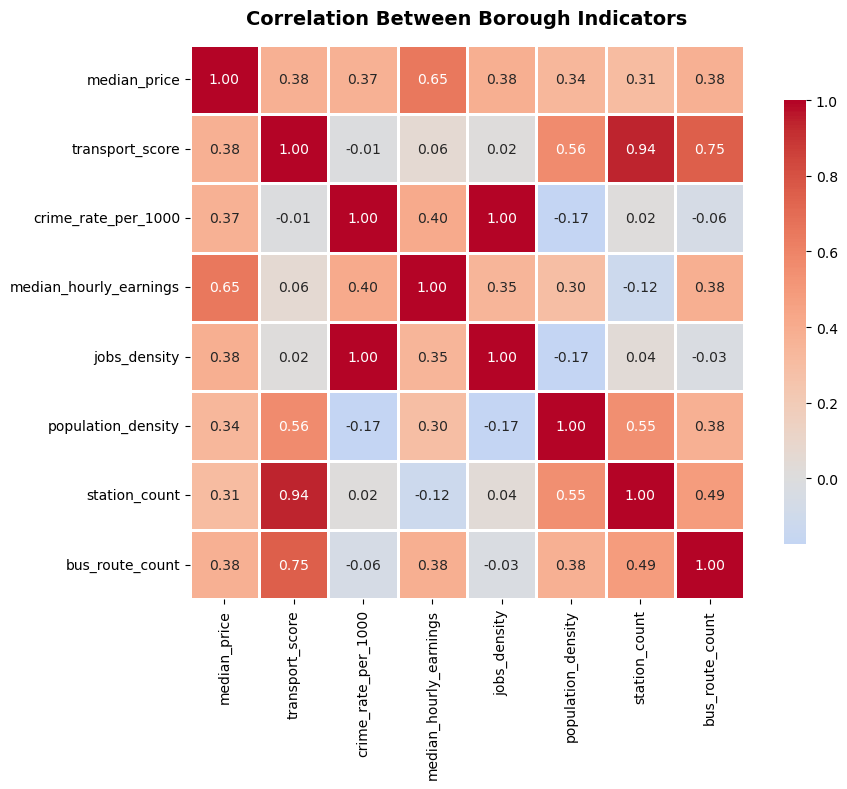


--- Strongest Positive Correlations ---
jobs_density         crime_rate_per_1000    0.998747
crime_rate_per_1000  jobs_density           0.998747
transport_score      station_count          0.940851
station_count        transport_score        0.940851
bus_route_count      transport_score        0.753008
dtype: float64

--- Strongest Negative Correlations ---
station_count        median_hourly_earnings   -0.121431
crime_rate_per_1000  population_density       -0.171433
population_density   crime_rate_per_1000      -0.171433
                     jobs_density             -0.173304
jobs_density         population_density       -0.173304
dtype: float64


In [51]:
# Correlation Analysis
print("Correlation Matrix - Key Indicators\n")

# Select numeric columns for correlation
numeric_cols = ['median_price', 'transport_score', 'crime_rate_per_1000', 
                'median_hourly_earnings', 'jobs_density', 'population_density',
                'station_count', 'bus_route_count']

corr_matrix = df[numeric_cols].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Between Borough Indicators', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Print strongest correlations
print("\n--- Strongest Positive Correlations ---")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1.0]  # Remove self-correlations
print(corr_pairs.head(5))

print("\n--- Strongest Negative Correlations ---")
print(corr_pairs.tail(5))

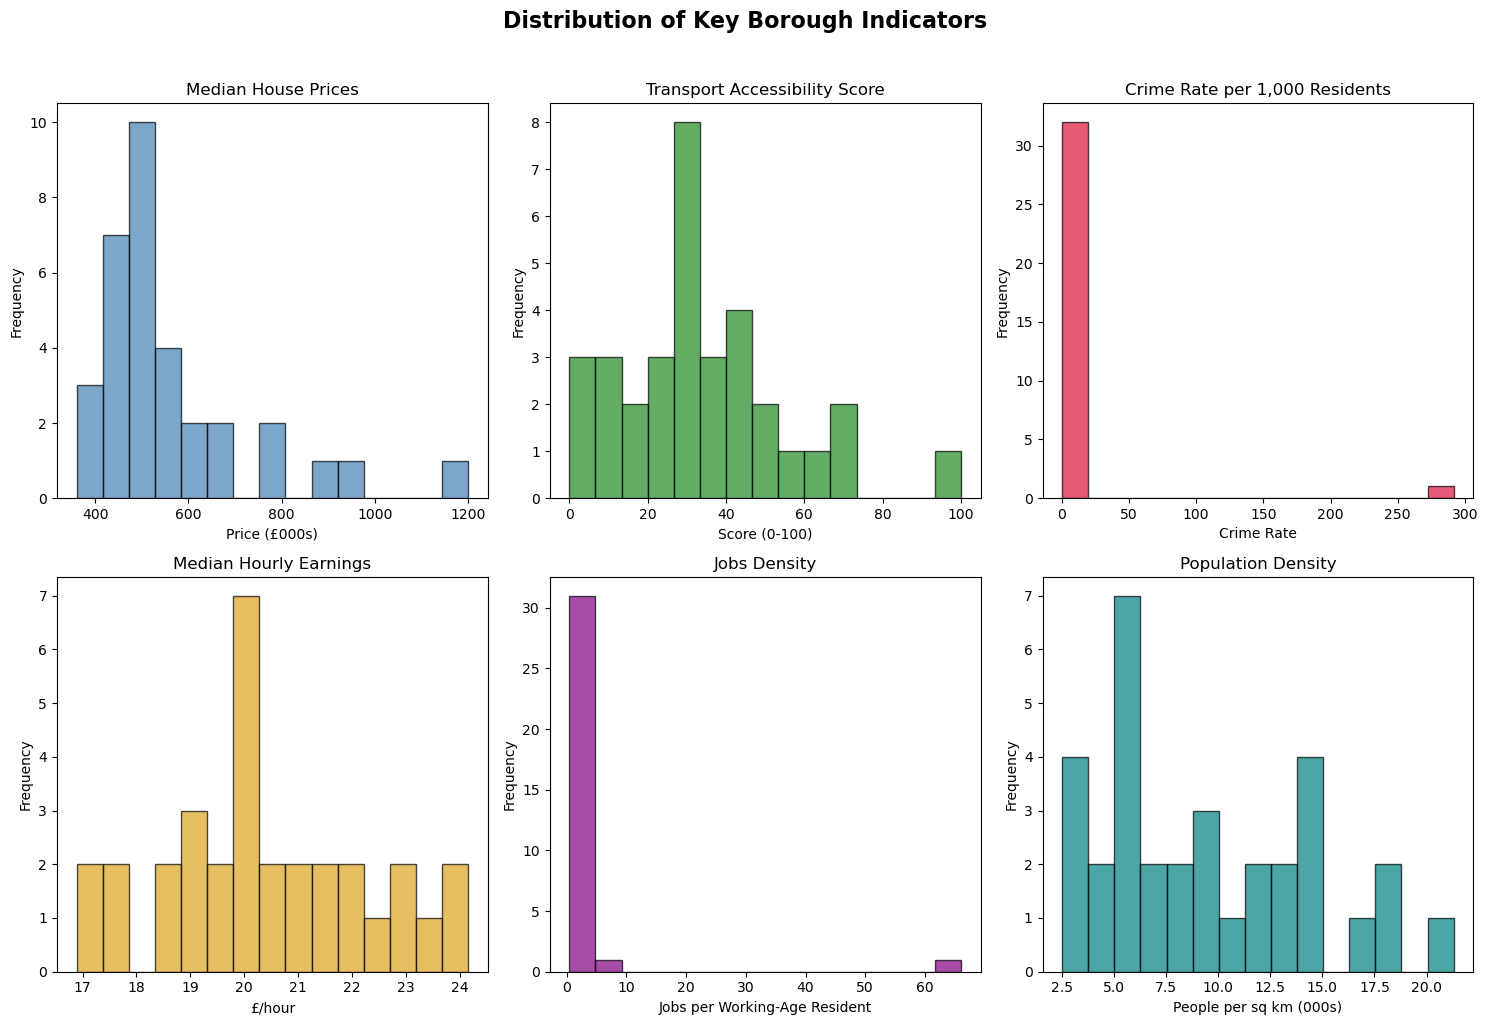

Distribution analysis complete


In [52]:
# Distribution of key indicators
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Borough Indicators', fontsize=16, fontweight='bold', y=1.02)

# 1. House Prices
axes[0, 0].hist(df['median_price']/1000, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Median House Prices')
axes[0, 0].set_xlabel('Price (£000s)')
axes[0, 0].set_ylabel('Frequency')

# 2. Transport Score
axes[0, 1].hist(df['transport_score'], bins=15, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Transport Accessibility Score')
axes[0, 1].set_xlabel('Score (0-100)')
axes[0, 1].set_ylabel('Frequency')

# 3. Crime Rate
axes[0, 2].hist(df['crime_rate_per_1000'], bins=15, color='crimson', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Crime Rate per 1,000 Residents')
axes[0, 2].set_xlabel('Crime Rate')
axes[0, 2].set_ylabel('Frequency')

# 4. Earnings
axes[1, 0].hist(df['median_hourly_earnings'].dropna(), bins=15, color='goldenrod', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Median Hourly Earnings')
axes[1, 0].set_xlabel('£/hour')
axes[1, 0].set_ylabel('Frequency')

# 5. Jobs Density
axes[1, 1].hist(df['jobs_density'], bins=15, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Jobs Density')
axes[1, 1].set_xlabel('Jobs per Working-Age Resident')
axes[1, 1].set_ylabel('Frequency')

# 6. Population Density
axes[1, 2].hist(df['population_density']/1000, bins=15, color='teal', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Population Density')
axes[1, 2].set_xlabel('People per sq km (000s)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Distribution analysis complete")

In [53]:
print("Investigating Crime Rate Distribution:")
print(df[['borough_name', 'crime_rate_per_1000']].sort_values('crime_rate_per_1000', ascending=False).head(10))

print("\n" + "="*60)

print("\nInvestigating Jobs Density Distribution:")
print(df[['borough_name', 'jobs_density']].sort_values('jobs_density', ascending=False).head(10))

print("\n" + "="*60)

# Check for extreme outliers
print("\nCrime rate stats:")
print(f"Mean: {df['crime_rate_per_1000'].mean():.2f}")
print(f"Median: {df['crime_rate_per_1000'].median():.2f}")
print(f"Max: {df['crime_rate_per_1000'].max():.2f}")

print("\nJobs density stats:")
print(f"Mean: {df['jobs_density'].mean():.2f}")
print(f"Median: {df['jobs_density'].median():.2f}")
print(f"Max: {df['jobs_density'].max():.2f}")

Investigating Crime Rate Distribution:
              borough_name  crime_rate_per_1000
32          City of London               291.59
24             Westminster                11.39
23  Kensington and Chelsea                 8.20
27               Islington                 6.36
22  Hammersmith and Fulham                 6.12
28                 Hackney                 5.04
25                  Camden                 4.76
10                 Lambeth                 3.58
26           Tower Hamlets                 3.56
11               Southwark                 3.50


Investigating Jobs Density Distribution:
              borough_name  jobs_density
32          City of London         66.02
24             Westminster          5.33
25                  Camden          2.71
27               Islington          1.67
11               Southwark          1.53
26           Tower Hamlets          1.46
23  Kensington and Chelsea          1.45
22  Hammersmith and Fulham          1.17
28                 Ha

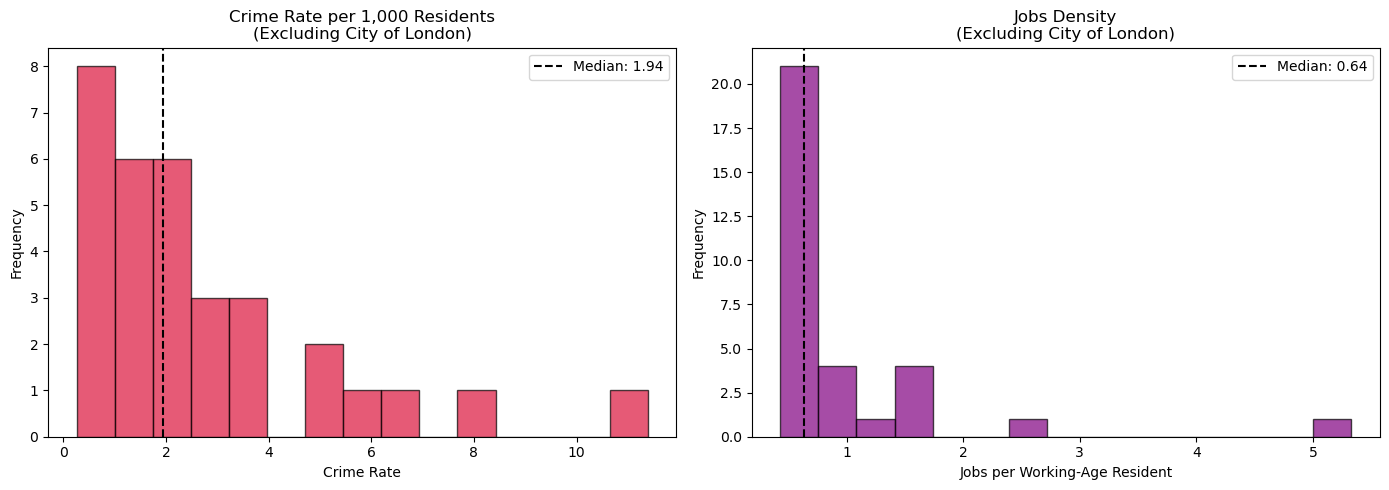

✓ Distributions shown (City of London excluded for clarity)

Note: City of London is extreme outlier in both metrics due to its unique nature
      (Commercial center with 10,604 residents but 759,000 jobs)


In [55]:
# Improved plots - exclude City of London from both
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Exclude City of London for clearer visualization
df_no_city = df[df['borough_name'] != 'City of London']

# Crime Rate
axes[0].hist(df_no_city['crime_rate_per_1000'], bins=15, color='crimson', edgecolor='black', alpha=0.7)
axes[0].set_title('Crime Rate per 1,000 Residents\n(Excluding City of London)', fontsize=12)
axes[0].set_xlabel('Crime Rate')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_no_city['crime_rate_per_1000'].median(), color='black', linestyle='--', label=f'Median: {df_no_city["crime_rate_per_1000"].median():.2f}')
axes[0].legend()

# Jobs Density
axes[1].hist(df_no_city['jobs_density'], bins=15, color='purple', edgecolor='black', alpha=0.7)
axes[1].set_title('Jobs Density\n(Excluding City of London)', fontsize=12)
axes[1].set_xlabel('Jobs per Working-Age Resident')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df_no_city['jobs_density'].median(), color='black', linestyle='--', label=f'Median: {df_no_city["jobs_density"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("✓ Distributions shown (City of London excluded for clarity)")
print(f"\nNote: City of London is extreme outlier in both metrics due to its unique nature")
print(f"      (Commercial center with 10,604 residents but 759,000 jobs)")

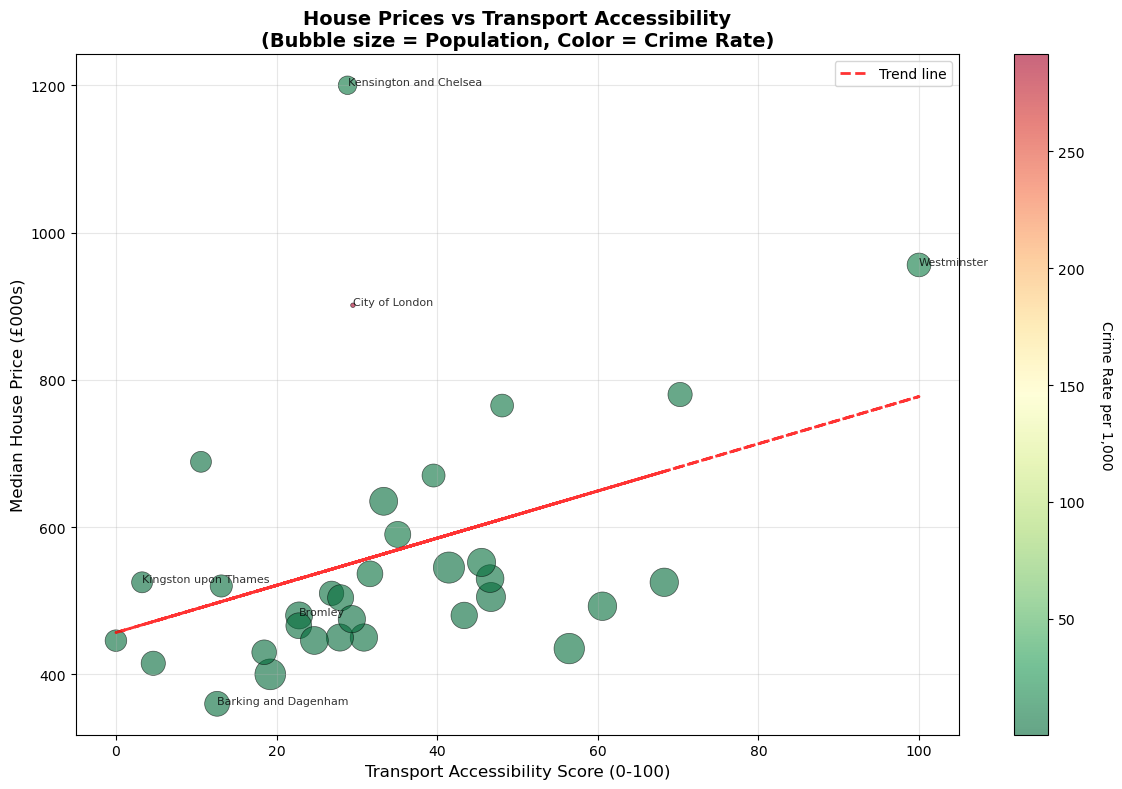


Correlation between Transport and Price: 0.379


In [56]:
# Price vs Transport Accessibility
fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot
scatter = ax.scatter(df['transport_score'], df['median_price']/1000, 
                     s=df['population']/1000, alpha=0.6, c=df['crime_rate_per_1000'], 
                     cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)

# Add trend line
z = np.polyfit(df['transport_score'], df['median_price']/1000, 1)
p = np.poly1d(z)
ax.plot(df['transport_score'], p(df['transport_score']), "r--", alpha=0.8, linewidth=2, label='Trend line')

# Labels for interesting boroughs
interesting = ['Westminster', 'City of London', 'Barking and Dagenham', 
               'Kingston upon Thames', 'Kensington and Chelsea', 'Bromley']
for idx, row in df.iterrows():
    if row['borough_name'] in interesting:
        ax.annotate(row['borough_name'], 
                   (row['transport_score'], row['median_price']/1000),
                   fontsize=8, alpha=0.8)

# Formatting
ax.set_xlabel('Transport Accessibility Score (0-100)', fontsize=12)
ax.set_ylabel('Median House Price (£000s)', fontsize=12)
ax.set_title('House Prices vs Transport Accessibility\n(Bubble size = Population, Color = Crime Rate)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Crime Rate per 1,000', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

# Calculate correlation
corr = df['transport_score'].corr(df['median_price'])
print(f"\nCorrelation between Transport and Price: {corr:.3f}")

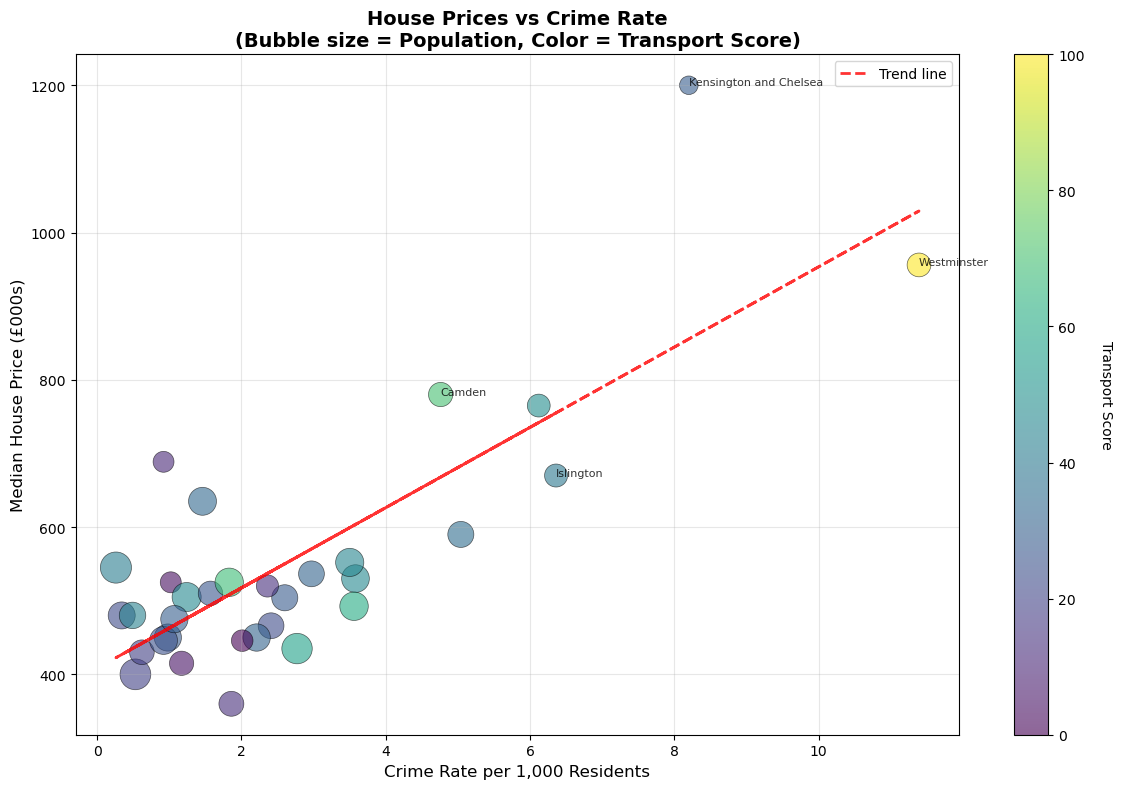


Correlation between Crime Rate and Price: 0.794
(Note: City of London excluded - crime rate of 291.59 would skew visualization)


In [58]:
# Price vs Crime Rate
fig, ax = plt.subplots(figsize=(12, 8))

# Exclude City of London for clearer visualization
df_plot = df[df['borough_name'] != 'City of London']

# Scatter plot
scatter = ax.scatter(df_plot['crime_rate_per_1000'], df_plot['median_price']/1000, 
                     s=df_plot['population']/1000, alpha=0.6, 
                     c=df_plot['transport_score'], cmap='viridis', 
                     edgecolors='black', linewidth=0.5)

# Trend line
z = np.polyfit(df_plot['crime_rate_per_1000'], df_plot['median_price']/1000, 1)
p = np.poly1d(z)
ax.plot(df_plot['crime_rate_per_1000'], p(df_plot['crime_rate_per_1000']), 
        "r--", alpha=0.8, linewidth=2, label='Trend line')

# Label extremes
extremes = df_plot.nlargest(3, 'crime_rate_per_1000')['borough_name'].tolist() + \
           df_plot.nlargest(3, 'median_price')['borough_name'].tolist()

for idx, row in df_plot.iterrows():
    if row['borough_name'] in extremes:
        ax.annotate(row['borough_name'], 
                   (row['crime_rate_per_1000'], row['median_price']/1000),
                   fontsize=8, alpha=0.8)

ax.set_xlabel('Crime Rate per 1,000 Residents', fontsize=12)
ax.set_ylabel('Median House Price (£000s)', fontsize=12)
ax.set_title('House Prices vs Crime Rate\n(Bubble size = Population, Color = Transport Score)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Transport Score', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

corr = df_plot['crime_rate_per_1000'].corr(df_plot['median_price'])
print(f"\nCorrelation between Crime Rate and Price: {corr:.3f}")
print("(Note: City of London excluded - crime rate of 291.59 would skew visualization)")

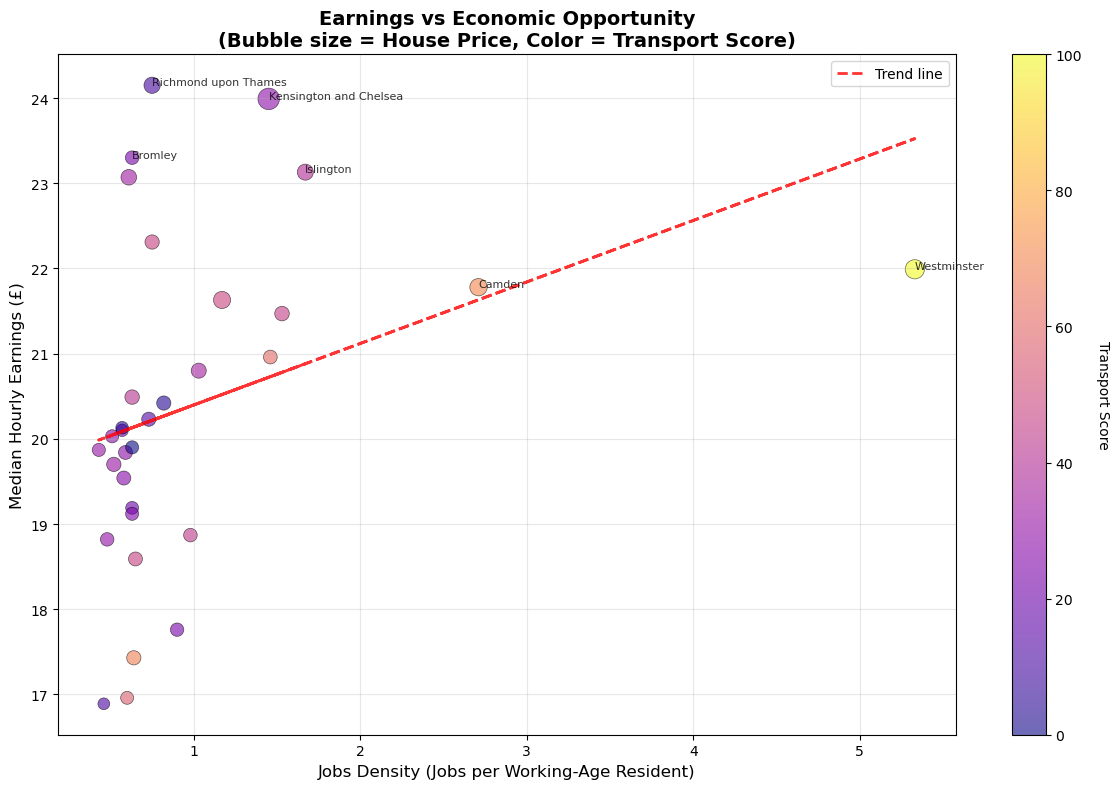


Correlation between Jobs Density and Earnings: 0.346
(City of London excluded - jobs density of 66.02 would dominate)


In [59]:
# Earnings vs Jobs Density - Economic Relationship
fig, ax = plt.subplots(figsize=(12, 8))

# Exclude City of London
df_plot = df[df['borough_name'] != 'City of London'].dropna(subset=['median_hourly_earnings'])

scatter = ax.scatter(df_plot['jobs_density'], df_plot['median_hourly_earnings'], 
                     s=df_plot['median_price']/5000, alpha=0.6, 
                     c=df_plot['transport_score'], cmap='plasma', 
                     edgecolors='black', linewidth=0.5)

# Trend line
z = np.polyfit(df_plot['jobs_density'], df_plot['median_hourly_earnings'], 1)
p = np.poly1d(z)
ax.plot(df_plot['jobs_density'], p(df_plot['jobs_density']), 
        "r--", alpha=0.8, linewidth=2, label='Trend line')

# Label interesting points
interesting = df_plot.nlargest(3, 'jobs_density')['borough_name'].tolist() + \
              df_plot.nlargest(3, 'median_hourly_earnings')['borough_name'].tolist()

for idx, row in df_plot.iterrows():
    if row['borough_name'] in interesting:
        ax.annotate(row['borough_name'], 
                   (row['jobs_density'], row['median_hourly_earnings']),
                   fontsize=8, alpha=0.8)

ax.set_xlabel('Jobs Density (Jobs per Working-Age Resident)', fontsize=12)
ax.set_ylabel('Median Hourly Earnings (£)', fontsize=12)
ax.set_title('Earnings vs Economic Opportunity\n(Bubble size = House Price, Color = Transport Score)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Transport Score', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

corr = df_plot['jobs_density'].corr(df_plot['median_hourly_earnings'])
print(f"\nCorrelation between Jobs Density and Earnings: {corr:.3f}")
print("(City of London excluded - jobs density of 66.02 would dominate)")

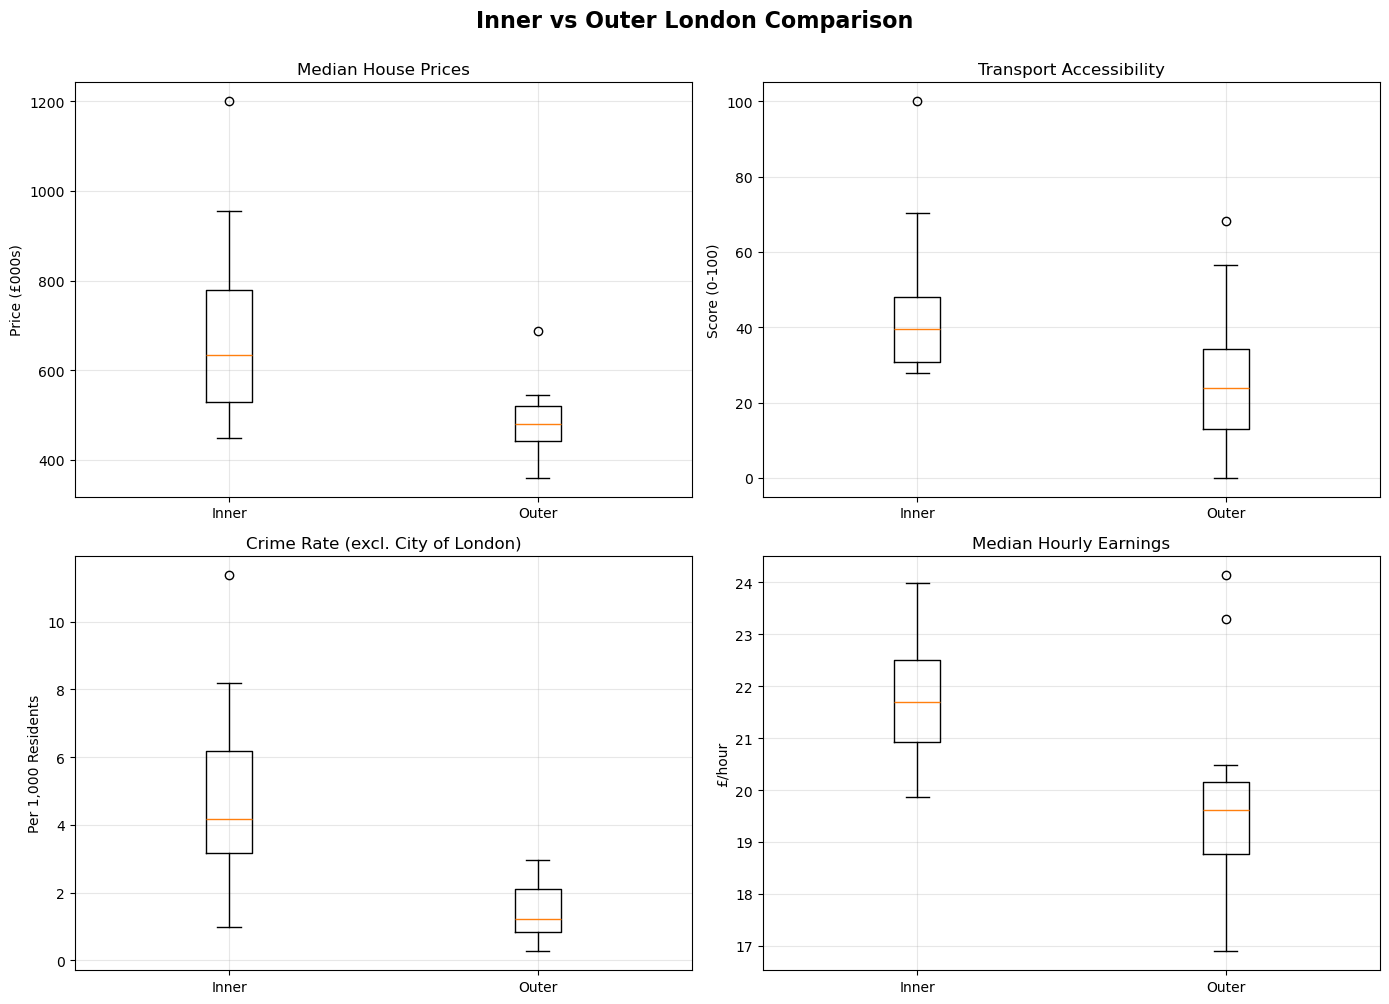

Inner vs Outer comparison complete

Inner London boroughs: 13
Outer London boroughs: 20


In [60]:
# Define Inner vs Outer London boroughs
inner_london = ['Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington',
                'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets',
                'Wandsworth', 'Westminster', 'City of London']

# Add classification column
df['london_type'] = df['borough_name'].apply(lambda x: 'Inner' if x in inner_london else 'Outer')

# Create box plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Inner vs Outer London Comparison', fontsize=16, fontweight='bold', y=1.00)

# 1. House Prices
axes[0, 0].boxplot([df[df['london_type']=='Inner']['median_price']/1000,
                     df[df['london_type']=='Outer']['median_price']/1000],
                    labels=['Inner', 'Outer'])
axes[0, 0].set_title('Median House Prices')
axes[0, 0].set_ylabel('Price (£000s)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Transport Score
axes[0, 1].boxplot([df[df['london_type']=='Inner']['transport_score'],
                     df[df['london_type']=='Outer']['transport_score']],
                    labels=['Inner', 'Outer'])
axes[0, 1].set_title('Transport Accessibility')
axes[0, 1].set_ylabel('Score (0-100)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Crime Rate (exclude City of London)
df_crime = df[df['borough_name'] != 'City of London']
axes[1, 0].boxplot([df_crime[df_crime['london_type']=='Inner']['crime_rate_per_1000'],
                     df_crime[df_crime['london_type']=='Outer']['crime_rate_per_1000']],
                    labels=['Inner', 'Outer'])
axes[1, 0].set_title('Crime Rate (excl. City of London)')
axes[1, 0].set_ylabel('Per 1,000 Residents')
axes[1, 0].grid(True, alpha=0.3)

# 4. Earnings
df_earnings = df[df['borough_name'] != 'City of London'].dropna(subset=['median_hourly_earnings'])
axes[1, 1].boxplot([df_earnings[df_earnings['london_type']=='Inner']['median_hourly_earnings'],
                     df_earnings[df_earnings['london_type']=='Outer']['median_hourly_earnings']],
                    labels=['Inner', 'Outer'])
axes[1, 1].set_title('Median Hourly Earnings')
axes[1, 1].set_ylabel('£/hour')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Inner vs Outer comparison complete")
print(f"\nInner London boroughs: {df['london_type'].value_counts()['Inner']}")
print(f"Outer London boroughs: {df['london_type'].value_counts()['Outer']}")

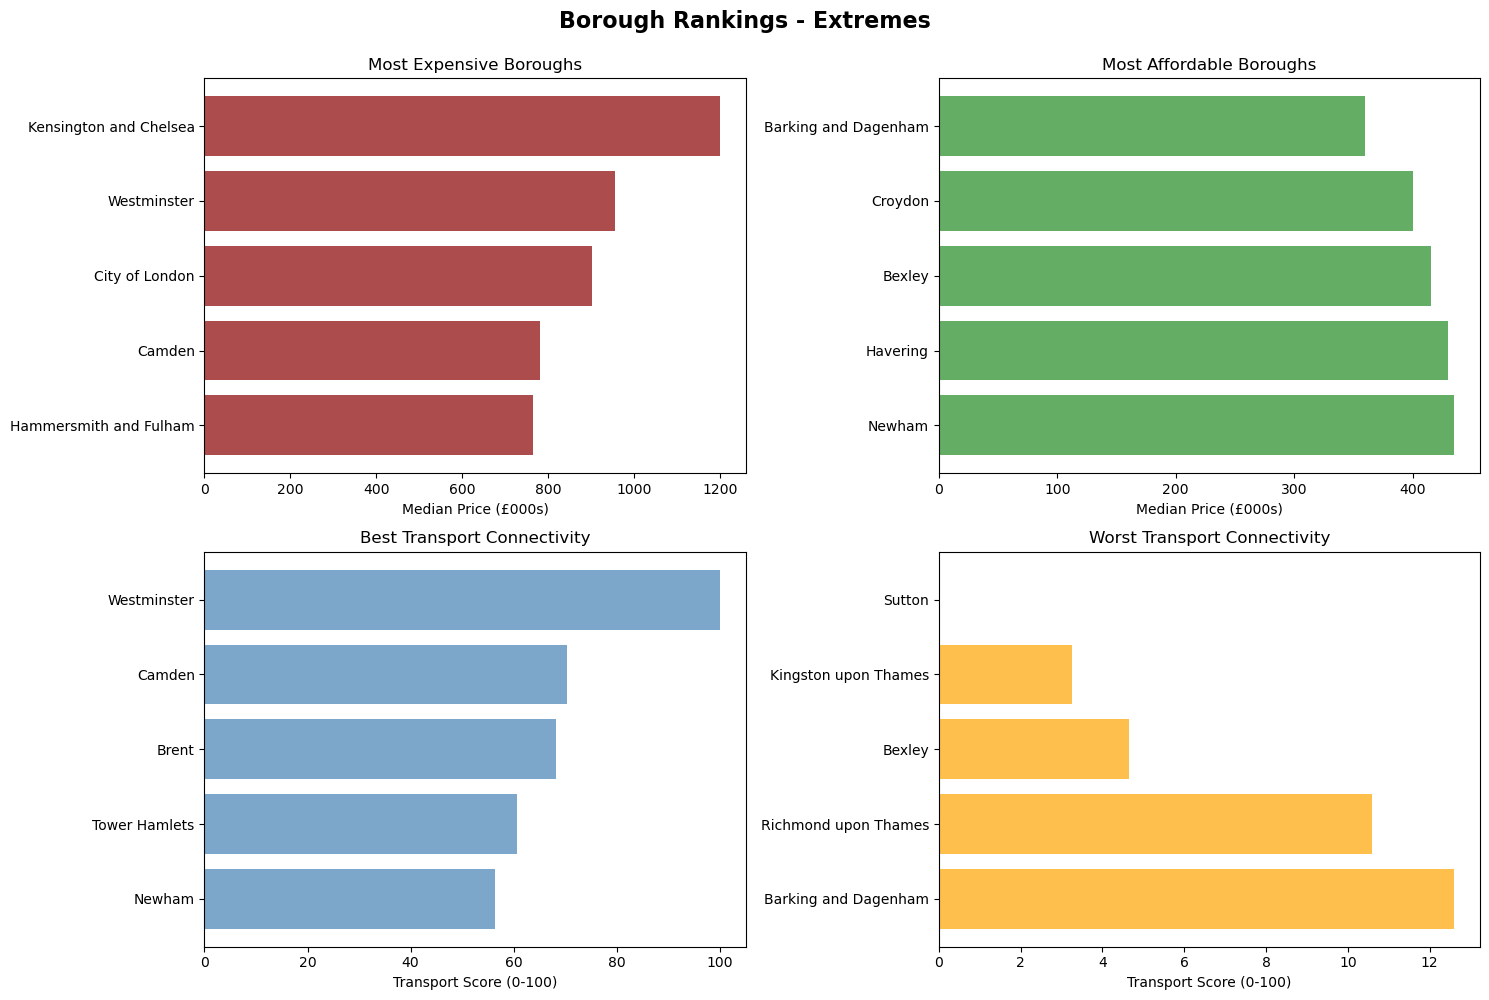

 Borough rankings visualized


In [62]:
# Borough Rankings - Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Borough Rankings - Extremes', fontsize=16, fontweight='bold', y=0.995)

# 1. Most vs Least Expensive
top_expensive = df.nlargest(5, 'median_price')
bottom_expensive = df.nsmallest(5, 'median_price')

axes[0, 0].barh(top_expensive['borough_name'], top_expensive['median_price']/1000, color='darkred', alpha=0.7)
axes[0, 0].set_xlabel('Median Price (£000s)')
axes[0, 0].set_title('Most Expensive Boroughs')
axes[0, 0].invert_yaxis()

axes[0, 1].barh(bottom_expensive['borough_name'], bottom_expensive['median_price']/1000, color='forestgreen', alpha=0.7)
axes[0, 1].set_xlabel('Median Price (£000s)')
axes[0, 1].set_title('Most Affordable Boroughs')
axes[0, 1].invert_yaxis()

# 2. Best vs Worst Transport
top_transport = df.nlargest(5, 'transport_score')
bottom_transport = df.nsmallest(5, 'transport_score')

axes[1, 0].barh(top_transport['borough_name'], top_transport['transport_score'], color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Transport Score (0-100)')
axes[1, 0].set_title('Best Transport Connectivity')
axes[1, 0].invert_yaxis()

axes[1, 1].barh(bottom_transport['borough_name'], bottom_transport['transport_score'], color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Transport Score (0-100)')
axes[1, 1].set_title('Worst Transport Connectivity')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(" Borough rankings visualized")

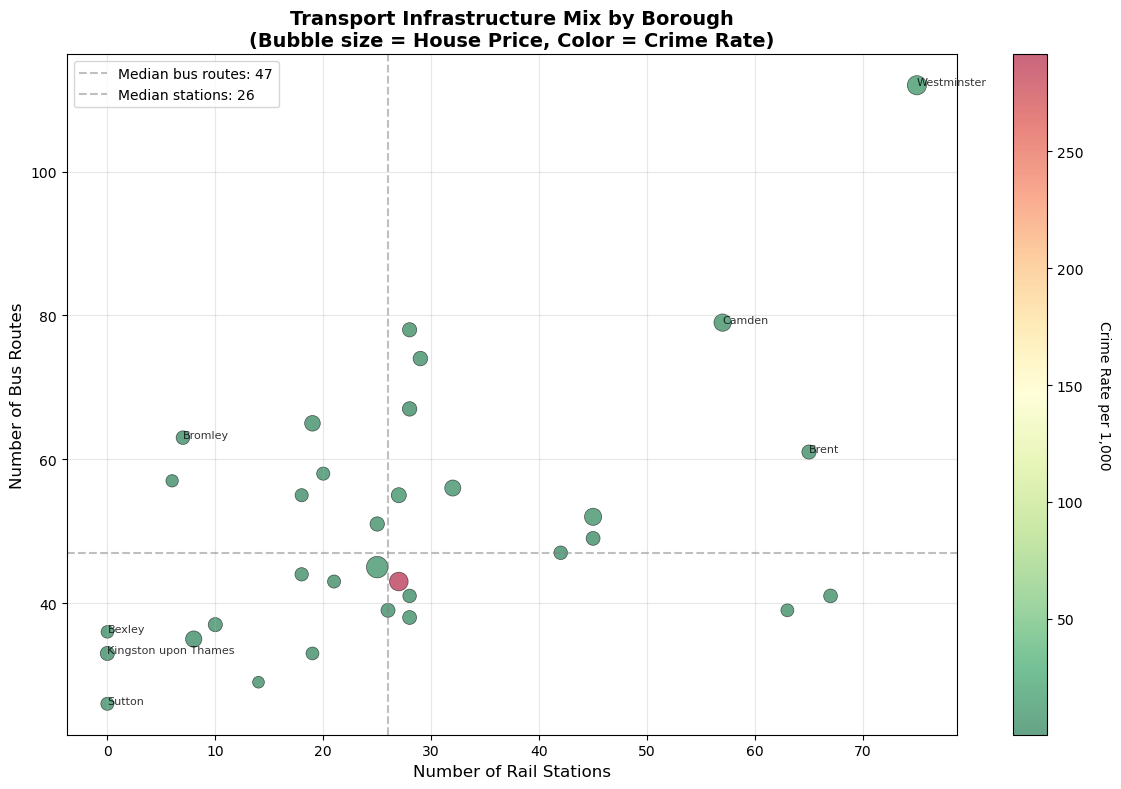

Transport infrastructure breakdown complete

Boroughs relying mainly on buses (0 stations): 3


In [63]:
# Transport Infrastructure Mix
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter: Station count vs Bus route count
scatter = ax.scatter(df['station_count'], df['bus_route_count'], 
                     s=df['median_price']/5000, alpha=0.6, 
                     c=df['crime_rate_per_1000'], cmap='RdYlGn_r',
                     edgecolors='black', linewidth=0.5)

# Label interesting boroughs
interesting = ['Westminster', 'Bexley', 'Kingston upon Thames', 'Sutton', 
               'Brent', 'Camden', 'Bromley']
for idx, row in df.iterrows():
    if row['borough_name'] in interesting:
        ax.annotate(row['borough_name'], 
                   (row['station_count'], row['bus_route_count']),
                   fontsize=8, alpha=0.8)

# Reference lines
ax.axhline(df['bus_route_count'].median(), color='gray', linestyle='--', alpha=0.5, label=f'Median bus routes: {df["bus_route_count"].median():.0f}')
ax.axvline(df['station_count'].median(), color='gray', linestyle='--', alpha=0.5, label=f'Median stations: {df["station_count"].median():.0f}')

ax.set_xlabel('Number of Rail Stations', fontsize=12)
ax.set_ylabel('Number of Bus Routes', fontsize=12)
ax.set_title('Transport Infrastructure Mix by Borough\n(Bubble size = House Price, Color = Crime Rate)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Crime Rate per 1,000', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print("Transport infrastructure breakdown complete")
print(f"\nBoroughs relying mainly on buses (0 stations): {len(df[df['station_count']==0])}")